# COMP2019 Group Assignment 

## Group 54789




### Authors and Contributions



- Robert Dicker - dicrw001: Worked on notes, summaries and code: Template, Methods, Prep 1a, 1b, 1c, 2a, 2b, 2c, 3a, 3b, 3c, 4a, 4b, 4c, 4d
- Benjamin Smith - smibj001: Worked on: Written summaries and explanations - 4d & 5. Some code in 1a, 2a, and 5.
- Libardo Abella Bohorquez - abely001. Worked on: Helper Methods, 1a, 1b, 1c, 2a, 2c, 3a, 3b, 3d, 4a, 4d, explanatory notes throughout
- Bijay Chamlagain - chaby037: Worked on: Helper Methods, 1a, 1c, 2a, 2c, 3a 3b, 3c, 3d, Fixed grammar, spelling and typo errors throughout

All team members collaborated and discussed 

#Imports, Settings and Helper Methods

## Mount



In [ ]:
#@title Mount Drive First
#@markdown This is only for if you are using the mounted version, we have commented it out so you can use the local version
# The csv files should be located here during development
# Comment out for submission
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Upgrade sklearn

For most of the tasks, the bundled version of scikit-learn does the job. But SequentialFeatureSelector is only available in the latest version of scikit-learn. Run this code if running the Selection Sequential Feature Selection (SFS) in the appendix. Otherwise, this can be skipped.

In [ ]:
# uninstalling current scikit and installing new scikit learn
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.2 MB 1.9 MB/s 


## Imports

In [ ]:
#@title Run to import all necessary libraries { display-mode: "form" }
# full library imports
import numpy as np
import pandas as pd
import seaborn as sns
import time

# partial imports
from math import floor
import matplotlib.pyplot as plt
# Changed the instance of figure to plt.figure
# from matplotlib.pyplot import figure

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz


# Tensorflow for Q4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Normalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.losses import  BinaryCrossentropy
from sklearn.metrics import classification_report
import tensorflow as tf



# This is the timer class we will use for testing how long the model takes
# use start to start the timer
# use stop to stop it, which will return the rounded elapsed time to 1 decimal place
class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        
        if self._start_time is not None:
            return "Timer is running. Use .stop() to stop it"

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            return "Timer is not running. Use .start() to start it"

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return round(elapsed_time,1)




# Configure settings
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option("display.max_columns", None)
sns.set_theme()

# This is our colour palette used for our seaborn charts
colourPalette = ['#5875a2', '#ff0000', '#00d000']

## Import the CSV files

In [ ]:
#@title Run to import all csv files { display-mode: "form" }
#@markdown Import documents locally - warning there has been an issue with local folder cutting the data set in two
#@markdown This is a known colab bug, and mounting via drive does not suffer this issue.
# Comment for submission. We have left this here for development or if you want to run from mounted drive
# trainDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/train.csv')
# testDf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/test.csv')

# Uncomment for submission
trainDf = pd.read_csv('train.csv')
testDf = pd.read_csv('test.csv')

# For consistency we will convert all the column names to uppercase
trainDf.columns = map(str.upper, trainDf.columns)
testDf.columns = map(str.upper, trainDf.columns)

## Helper Methods 

In [ ]:
#@title Run to import all the necessary helper methods { display-mode: "form" }

# Takes a set of features feature selection, and the dataFrame that contains the target,
# and a metric from a classifaction report as a string and returns two scores the dev train score and test score
# as well as returning duration 
# returns (devSetAccuracy, testSetAccuracy, Duration)
def trainPrintAndReturnMetric(featureSelection, X_train, X_test, Y_train, Y_test, metric='accuracy', C=1, model=None):
    t = Timer()
    t.start()
    if not model:
        model = LogisticRegression(max_iter=10000, C=C)
    model.fit(X_train[featureSelection], Y_train)

    y_pred = model.predict(X_train[featureSelection])
    y_test_pred = model.predict(X_test[featureSelection])
    
    duration = t.stop()
    report = classification_report(Y_train, y_pred,output_dict=True)     
    testReport = classification_report(Y_test, y_test_pred, output_dict=True)

    # Print generic info about the model and no of features
    print(f"\n**Model: {model}**")
    print(f"Number of features: {len(featureSelection)}\n")

    # Print results
    print("\nTraining Classification Results")
    print(classification_report(Y_train, y_pred))
    print("\nDev Classification Results")
    print(classification_report(Y_test, y_test_pred))  
    
    #return the accuracy for the dev test report and test report
    if metric == 'accuracy':
        return round(report['accuracy'], 3), round(testReport['accuracy'], 3), duration 

    return round(report['macro avg'][metric], 3), round(testReport['macro avg'][metric], 3), duration

# Used in Section 3 - decision Tree
# takes the training and test data, fits and returns the prediction train and prediction test
def getPredictions(X_train, Y_train, X_test, model):    
    model.fit(X_train, Y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    return pred_train, pred_test

# Used in section 3 DT
# This takes the given parameters and prints out the confusion matrix as well as classification reports
# on both the training and test data for comparison
def displayMetrics(Y_train, Y_pred_train, Y_test, Y_pred_test, modelLabels):
    # I have done it this way as per sklearn api - Deprecated since version 1.0: plot_confusion_matrix is deprecated in 1.0 and will be removed in 1.2.
    #TRAINING SET
    confusionMatrixTrain = confusion_matrix(Y_train, Y_pred_train, labels=modelLabels, normalize='true')
    confusionMatrixTest = confusion_matrix(Y_test, Y_pred_test, labels=modelLabels,  normalize='true')

    # Image options
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    fig.suptitle('Confusion matrix of our model subplots - results normalized')
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)

    # Plot the matrix side by side
    cmTrain = ConfusionMatrixDisplay(confusion_matrix=confusionMatrixTrain,display_labels=modelLabels)
    cmTest = ConfusionMatrixDisplay(confusion_matrix=confusionMatrixTest,display_labels=modelLabels)
    cmTrain.plot(ax=ax1)
    cmTest.plot(ax=ax2)
    print("\nTrain Classification Results")
    print(classification_report(Y_train, Y_pred_train), )
    print("Dev Test Classification Results")
    print(classification_report(Y_test, Y_pred_test))
  

# Used in Section 2 - PCA
def hyperparameter_tuning(pipeline, params, X_train, Y_train, X_test, Y_test):
    model = GridSearchCV(pipeline, params, cv=4, verbose=True, n_jobs=-1)
    model.fit(X_train, Y_train)
    
    print(f"***\nHyperparameter tuning for {pipeline}\n")
    print(f"The best parameters found were: {model.best_params_}\n***")

# Used in Section 2
# Plots the learning curve of the estimator given the train and target data
def plot_learning_curve(estimator, X_train, Y_train):
    # Clone the estimator (model or pipeline) so as not to affect the original one
    estimator = clone(estimator)

    # Generate learning curve values
    train_sizes, train_scores, test_scores = learning_curve(estimator, X=X_train, y=Y_train, 
                                                        cv=5, train_sizes=np.arange(0.05,0.95,0.05), 
                                                        n_jobs=-1)
    
    # prepare plot data
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # prepare plot
    sns.set(rc={'figure.figsize':(10,6)})
    sns.lineplot(x=train_sizes, y=train_scores_mean, marker='o', color='blue', label='Training accuracy')
    plt.fill_between(train_sizes, train_scores_mean + train_scores_std, train_scores_mean - train_scores_std, alpha=0.15, color='blue')
    sns.lineplot(x=train_sizes, y=test_scores_mean, marker='o', color='green', label='Test accuracy')
    plt.fill_between(train_sizes, test_scores_mean + test_scores_std, test_scores_mean - test_scores_std, alpha=0.15, color='green')
    print(f"***\nLearning curve for {estimator}\n***")
    plt.title(f'Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    
    # plot
    plt.show()

# Used in Section 1
# Add percentage to seaborn plots
def plotWithPercentage(sns, total):
  for p in sns.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    sns.annotate(percentage, (x, y),ha='center', va='top')


# Used in section 4 
# Plots the accuracy and loss takes a score dictionary array, a value array for the x axis of same size and label for the x axis of the same size
# The output will be the dataframe, and the accuracy and loss charts plotted
def plotModelAccuracyAndLoss(scoreDictArray, xValueArray, xLabel):
    
    accuracyArray = []
    lossArray = []
    for score in scoreDictArray:
        accuracyArray.append(score['accuracy'])
        lossArray.append(score['loss'])

    scoreDict = {xLabel : xValueArray, 'ACCURACY':accuracyArray, 'LOSS':lossArray}

    scoreDf = pd.DataFrame(data=scoreDict)

    fig, ax = plt.subplots()
    plt.title("ACCURACY v "+ xLabel)
    plt.xlabel(xLabel)
    plt.ylabel("ACCURACY")
    scoreDf.plot(x=xLabel, y="ACCURACY", marker="o",  ax=ax);
    fig, ax2 = plt.subplots()
    plt.title("LOSS v "+ xLabel)
    plt.ylabel("LOSS")
    scoreDf.plot(x=xLabel, y="LOSS", marker="o", ax=ax2);
    display(scoreDf)
    print("\n\n")


# 1. Data Preparation and Review

### 1a) Understanding the Data

As part of the first step, we import our data for examination. We have two dataframes 

*   trainDf - our training (and development) dataset which also contains our target
*   testDf - our evaluation test set, that is to be used exclusively for evaluating how our models perform on wild, never before seen data.  

The data dictionary below was used to assist in understanding and evaluating the types of data we had. 

#### Data dictionary  

• Gender: Gender of the passengers (0 - Male, 1 - Female)  
• Customer Type: The customer type (0 - Disloyal customer, 1 - Loyal customer)  
• Age: The actual age of the passengers in years  
• Type of Travel: Purpose of the flight of the passengers (0 - Personal Travel, 1 -
Business Travel)  
• Class: Travel class in the plane of the passengers (0 – Eco, 1 – Eco+, 2 - Business)  
• Flight distance: The flight distance of this journey in miles  
• Inflight wifi service: Satisfaction level of the inflight wifi service (0-5)  
• Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time
convenient (0-5)  
• Ease of Online booking: Satisfaction level of online booking (0-5)  
• Gate location: Satisfaction level of Gate location (0-5)  
• Food and drink: Satisfaction level of Food and drink (0-5)  
• Online boarding: Satisfaction level of online boarding (0-5)  
• Seat comfort: Satisfaction level of Seat comfort (0-5)  
• Inflight entertainment: Satisfaction level of inflight entertainment (0-5)  
• On-board service: Satisfaction level of On-board service (0-5)  
• Leg room service: Satisfaction level of Leg room service (0-5)  
• Baggage handling: Satisfaction level of baggage handling (0-5)  
• Check-in service: Satisfaction level of Check-in service (0-5)  
• Inflight service: Satisfaction level of inflight service (0-5)  
• Cleanliness: Satisfaction level of Cleanliness (0-5)  
• Departure Delay in Minutes: Minutes delayed on departure (0-x)  
• Arrival Delay in Minutes: Minutes delayed on arrival (0-x)  
• Order: Aggregate score of satisfaction with ordering/arrival (0-5)  
• Comfort: Aggregate score of comfort (0-5)  
• Service: Aggregate score of service (0-5)  
**• Satisfaction: Airline satisfaction level (0 – Neutral or dissatisfied; 1 - Satisfied). This is
the target to predict.**

#### Data examination

In [ ]:
trainDf.head()

GENDER  CUSTOMER TYPE  AGE  TYPE OF TRAVEL  CLASS  FLIGHT DISTANCE  \
0       0              1   13               0      1              460   
1       0              0   25               1      2              235   
2       1              1   26               1      2             1142   
3       1              1   25               1      2              562   
4       0              1   61               1      2              214   

   INFLIGHT WIFI SERVICE  DEPARTURE/ARRIVAL TIME CONVENIENT  \
0                      3                                  4   
1                      3                                  2   
2                      2                                  2   
3                      2                                  5   
4                      3                                  3   

   EASE OF ONLINE BOOKING  GATE LOCATION  FOOD AND DRINK  ONLINE BOARDING  \
0                       3              1               5                3   
1                       3              3               1                3   
2                       2              2               5                5   
3                       5              5               2                2   
4                       3              3               4                5   

   SEAT COMFORT  INFLIGHT ENTERTAINMENT  ON-BOARD SERVICE  LEG ROOM SERVICE  \
0             5                       5                 4                 3   
1             1                       1                 1                 5   
2             5                       5                 4                 3   
3             2                       2                 2                 5   
4             5                       3                 3                 4   

   BAGGAGE HANDLING  CHECKIN SERVICE  INFLIGHT SERVICE  CLEANLINESS  \
0                 4                4                 5            5   
1                 3                1                 4            1   
2                 4                4                 4            5   
3                 3                1                 4            2   
4                 4                3                 3            3   

   DEPARTURE DELAY IN MINUTES  ARRIVAL DELAY IN MINUTES  ORDER  COMFORT  \
0                          25                        18   2.75     4.50   
1                           1                         6   2.75     1.50   
2                           0                         0   2.00     5.00   
3                          11                         9   4.25     2.00   
4                           0                         0   3.00     4.25   

   SERVICE  SATISFACTION  
0     4.00             0  
1     3.25             0  
2     3.75             1  
3     3.50             0  
4     3.50             1

All of the columns contain numerical values. Some of the features indicate categorical data; for instance, GENDER is encoded as 0 (Male) and 1 (Female) and CUSTOMER TYPE (0, 1 for loyal/disloyal customer). Other variables are continuous, such as FLIGHT DISTANCE, ARRIVAL DELAY IN MINUTES and DEPARTURE DELAY IN MINUTES. The target variable (i.e. SATISFACTION) is categorical.

In [ ]:
print("Training set shape: \t ",  trainDf.shape, "\nTest Set Shape:\t\t ", testDf.shape, "\n\n")
trainDf.describe()

Training set shape: 	  (103594, 26) 
Test Set Shape:		  (25893, 26) 




GENDER  CUSTOMER TYPE            AGE  TYPE OF TRAVEL  \
count  103594.000000  103594.000000  103594.000000   103594.000000   
mean        0.507520       0.817248      39.380466        0.689857   
std         0.499946       0.386465      15.113125        0.462554   
min         0.000000       0.000000       7.000000        0.000000   
25%         0.000000       1.000000      27.000000        0.000000   
50%         1.000000       1.000000      40.000000        1.000000   
75%         1.000000       1.000000      51.000000        1.000000   
max         1.000000       1.000000      85.000000        1.000000   

               CLASS  FLIGHT DISTANCE  INFLIGHT WIFI SERVICE  \
count  103594.000000    103594.000000          103594.000000   
mean        1.028380      1189.325202               2.729753   
std         0.962868       997.297235               1.327866   
min         0.000000        31.000000               0.000000   
25%         0.000000       414.000000               2.000000   
50%         1.000000       842.000000               3.000000   
75%         2.000000      1743.000000               4.000000   
max         2.000000      4983.000000               5.000000   

       DEPARTURE/ARRIVAL TIME CONVENIENT  EASE OF ONLINE BOOKING  \
count                      103594.000000           103594.000000   
mean                            3.060081                2.756984   
std                             1.525233                1.398934   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                             5.000000                5.000000   

       GATE LOCATION  FOOD AND DRINK  ONLINE BOARDING   SEAT COMFORT  \
count  103594.000000   103594.000000    103594.000000  103594.000000   
mean        2.977026        3.202126         3.250497       3.439765   
std         1.277723        1.329401         1.349433       1.318896   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       INFLIGHT ENTERTAINMENT  ON-BOARD SERVICE  LEG ROOM SERVICE  \
count           103594.000000     103594.000000     103594.000000   
mean                 3.358341          3.382609          3.351401   
std                  1.333030          1.288284          1.315409   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       BAGGAGE HANDLING  CHECKIN SERVICE  INFLIGHT SERVICE    CLEANLINESS  \
count     103594.000000    103594.000000     103594.000000  103594.000000   
mean           3.631687         3.304323          3.640761       3.286397   
std            1.181051         1.265396          1.175603       1.312194   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       DEPARTURE DELAY IN MINUTES  ARRIVAL DELAY IN MINUTES          ORDER  \
count               103594.000000             103594.000000  103594.000000   
mean                    14.747939                 15.178678       2.8809

Looking at some of the descriptive statistics of the data, we find that the majority of the features are within the same scale range of 0-5. However, there are a few outliers we can see from the min-max values, such as FLIGHT DISTANCE, ARRIVAL DELAY IN MINUTES and DEPARTURE DELAY IN MINUTES which may have an impact on our model. Furthermore, we notice the standard deviation is quite significant in those specific features as is their distribution. This provides an opportunity for data normalisation that we address at a later stage.

In [ ]:
print("Feature Variance\n")
trainDf.var().sort_values(ascending=False)

Feature Variance



FLIGHT DISTANCE                      994601.774592
ARRIVAL DELAY IN MINUTES               1497.587990
DEPARTURE DELAY IN MINUTES             1452.885641
AGE                                     228.406556
DEPARTURE/ARRIVAL TIME CONVENIENT         2.326335
EASE OF ONLINE BOOKING                    1.957015
ONLINE BOARDING                           1.820969
INFLIGHT ENTERTAINMENT                    1.776970
FOOD AND DRINK                            1.767308
INFLIGHT WIFI SERVICE                     1.763229
SEAT COMFORT                              1.739487
LEG ROOM SERVICE                          1.730300
CLEANLINESS                               1.721853
ON-BOARD SERVICE                          1.659677
GATE LOCATION                             1.632575
CHECKIN SERVICE                           1.601227
BAGGAGE HANDLING                          1.394882
INFLIGHT SERVICE                          1.382042
ORDER                                     1.131843
COMFORT                        

When we have a look at the feature variance we can see the extremes we established before. As those values difference approaches zero they may have little impact on our model, conversely, those exceptionally high variance features may have too much impact. Dropping them at this stage would be unwise until we've had the opportunity for deeper evaluation.

In [ ]:
# Examine Unique Values
print("Unique Values\n")
trainDf.nunique()

Unique Values



GENDER                                  2
CUSTOMER TYPE                           2
AGE                                    75
TYPE OF TRAVEL                          2
CLASS                                   3
FLIGHT DISTANCE                      3802
INFLIGHT WIFI SERVICE                   6
DEPARTURE/ARRIVAL TIME CONVENIENT       6
EASE OF ONLINE BOOKING                  6
GATE LOCATION                           6
FOOD AND DRINK                          6
ONLINE BOARDING                         6
SEAT COMFORT                            6
INFLIGHT ENTERTAINMENT                  6
ON-BOARD SERVICE                        6
LEG ROOM SERVICE                        6
BAGGAGE HANDLING                        5
CHECKIN SERVICE                         6
INFLIGHT SERVICE                        6
CLEANLINESS                             6
DEPARTURE DELAY IN MINUTES            445
ARRIVAL DELAY IN MINUTES              455
ORDER                                  20
COMFORT                           

The number of unique values across features shows various types of variables. GENDER, CUSTOMER TYPE, TYPE OF TRAVEL and SATISFACTION (our target feature) are binary categorical variables as we noticed earlier.  

Many features have 6 unique values which appear to be score based, these correspond to values ranging from (0 to 5 inclusive). Our data dictionary outlines that they are satisfaction scores with 0 being negative and 5 being positive.

Features like COMFORT, SERVICE and ORDER have a wider spectrum of values, but still range between 0 and 5. This is because, as the data dictionary highlights, they are aggregate values and include decimal numbers.

Other variables like AGE, FLIGHT DISTANCE and 'DELAYS' (DEPARTURE and ARRIVAL) have the widest range of values, due to the fact that these are continuous variables as mentioned previously.

In [ ]:
# Examine for Null Values
print("Nulls in Training Set\n")
print(trainDf.isnull().sum())
print("\nNulls in Test Set \n")
print(testDf.isnull().sum())

Nulls in Training Set

GENDER                               0
CUSTOMER TYPE                        0
AGE                                  0
TYPE OF TRAVEL                       0
CLASS                                0
FLIGHT DISTANCE                      0
INFLIGHT WIFI SERVICE                0
DEPARTURE/ARRIVAL TIME CONVENIENT    0
EASE OF ONLINE BOOKING               0
GATE LOCATION                        0
FOOD AND DRINK                       0
ONLINE BOARDING                      0
SEAT COMFORT                         0
INFLIGHT ENTERTAINMENT               0
ON-BOARD SERVICE                     0
LEG ROOM SERVICE                     0
BAGGAGE HANDLING                     0
CHECKIN SERVICE                      0
INFLIGHT SERVICE                     0
CLEANLINESS                          0
DEPARTURE DELAY IN MINUTES           0
ARRIVAL DELAY IN MINUTES             0
ORDER                                0
COMFORT                              0
SERVICE                              0
SA

Neither dataset contains missing values across any of the features or target variables, which means no additional transformation will be required to correct it.
 

#### Feature Distribution and Balance

We now turn our focus to examining the distribution and balance of features and the target variable, as well as identifying any visual patterns that may help select relevant features.

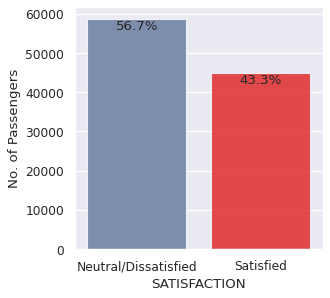

In [ ]:
plt.figure(figsize=(4, 4), dpi=80)
ax = sns.countplot(data = trainDf, x='SATISFACTION', palette=colourPalette, alpha=0.8);
ax.set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
total = float(len(trainDf))
plotWithPercentage(ax, total)
plt.ylabel('No. of Passengers')   
plt.show()



Looking at our 'SATISFACTION' target there appears to be a slight imbalance, with 0 (Neutral/Dissatisfied) having 58697 samples, and 1 (Satisfied) having 44897 (i.e. 56.7% vs 43.3%). While this may not be a significant difference, this could potentially affect how well our model recalls specific values. Therefore, it is worth ensuring, when splitting our datasets for ML training and evaluation, that this is done evenly on the target variable (by using stratification). This imbalance may also affect the metric we choose to use discussed in 1c.



To better visualise the distribution across features, we separate feature types into three categories: 

- Nominal features: These are categorical variables that don't have evaluative distinction (one value is not greater than the other). Examples are GENDER and CUSTOMER TYPE.

- Ordinal features: These are categorical variables that do have evaluative connotations (one value can be greater than the other). Most of the satisfaction scores fall in this category (except the target variable).

- Continuous features: These are variables that can potentially take an uncountable number of values, for instance FLIGHT DISTANCE

This will allow using appropriate distribution plots and we will be in a position to compare different features according to their nature.

In [ ]:
nominal_features = ['GENDER', 'CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS']
ordinal_features = ['INFLIGHT WIFI SERVICE', 'DEPARTURE/ARRIVAL TIME CONVENIENT', 
                    'EASE OF ONLINE BOOKING', 'GATE LOCATION', 'FOOD AND DRINK', 'ONLINE BOARDING', 
                    'SEAT COMFORT', 'INFLIGHT ENTERTAINMENT', 'ON-BOARD SERVICE', 'LEG ROOM SERVICE',
                    'BAGGAGE HANDLING', 'CHECKIN SERVICE', 'INFLIGHT SERVICE', 'CLEANLINESS']
continuous_features = [col for col in trainDf.columns 
                       if col not in nominal_features 
                       and col not in ordinal_features 
                       and col != 'SATISFACTION']

Let's examine the distribution for each feature type, starting with binary features:

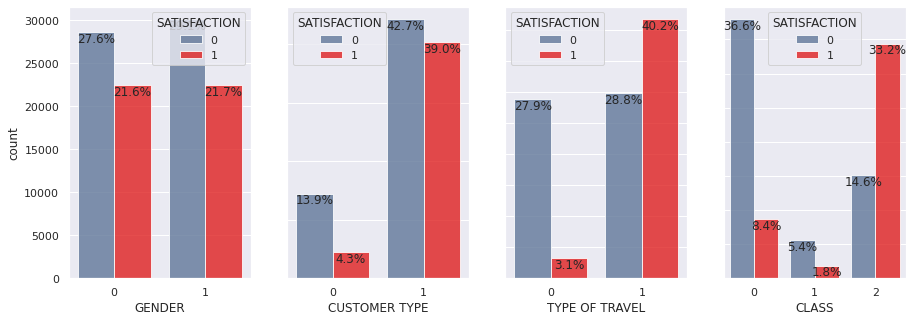

In [ ]:
fig, axs = plt.subplots(1, len(nominal_features))
totalData = len(trainDf)
for idx, feature in enumerate(nominal_features):
    snsPlot = sns.countplot(data=trainDf, x=feature,  ax=axs[idx], palette=colourPalette, alpha=0.8, hue="SATISFACTION")
    plotWithPercentage(snsPlot, total)

for ax in axs.flat:
    ax.label_outer()
    
fig.set_size_inches(15, 5)
plt.show()

GENDER appears to be balanced between Male (0) and Female (1), both distribution of gender and satisfaction. 

CUSTOMER TYPE is heavily skewed towards 'Loyal Customer' (1) when compared to 'Disloyal Customer' (0). We identify that those loyal customers are much more likely to have higher satisfaction than disloyal customers. 

In the TYPE OF TRAVEL, there appears to be significantly more prevalence of 'Business Travel' (1) when compared to 'Personal Travel'. But the dissatisfaction is much more pronounced for personal travel than that of business which has a more even distribution.

The CLASS distribution shows the majority of travellers are either economy (0) or business (2), with a very low prevalence for economy+ (1).

Next, let's look at the distribution of the categorical features:

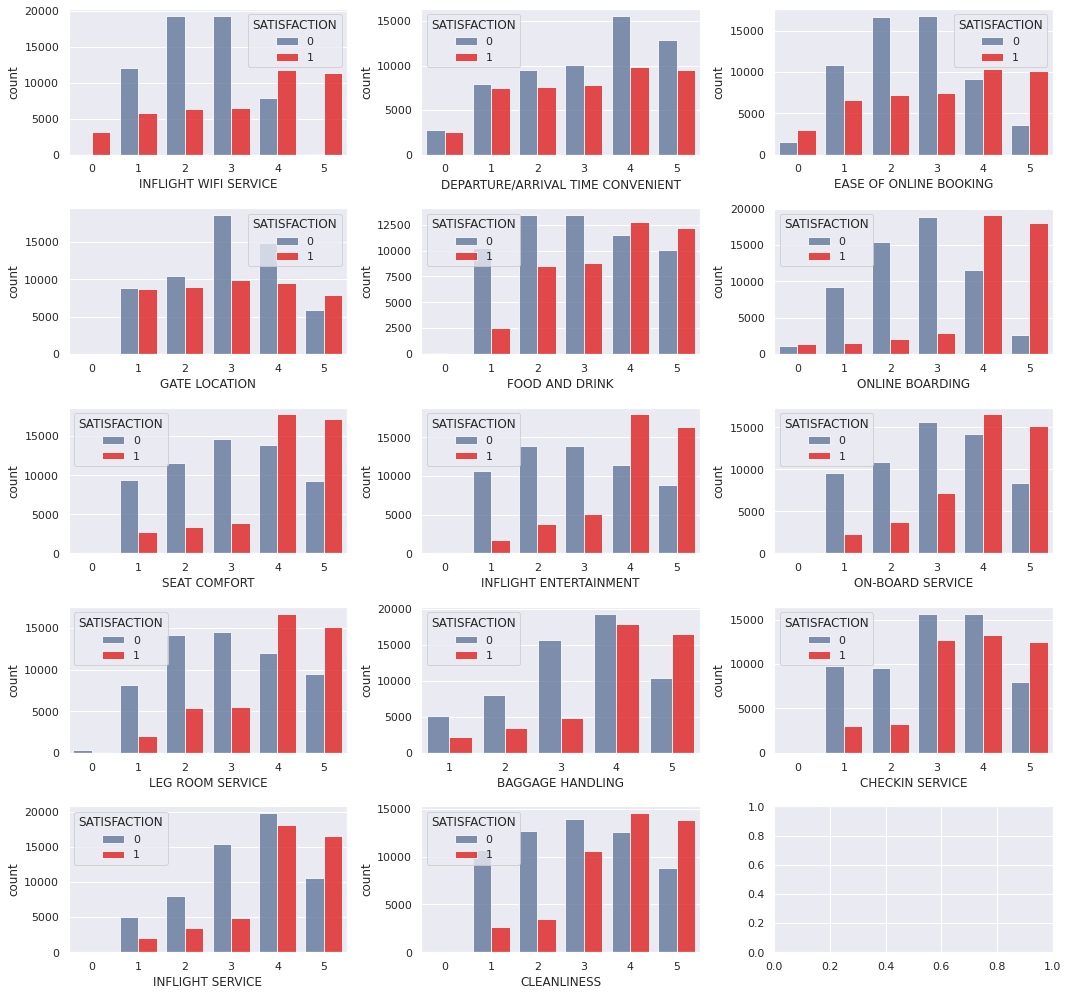

In [ ]:
fig, axs = plt.subplots(5, 3)
for idx, feature in enumerate(ordinal_features):
    sns.countplot(data=trainDf, x=feature,  ax=axs[idx // 3, idx % 3], palette=colourPalette, alpha=0.8, hue='SATISFACTION')
    
fig.set_size_inches(15, 14)
plt.tight_layout()
plt.show()

Across most categories, there appears to be more presence of scores in the 3-5 range, with many categories showing non-existing or very minimal zero scores. DEPARTURE ARRIVAL, EASE OF ONLINE BOOKING and EASE OF ONLINE BOARDING do show the existence of zero scores. GATE LOCATION and INFLIGHT WIFI SERVICE show the distribution balanced around the centre, whilst most other categories have heavier weights towards the higher scores.

We see some expected results regarding our Satisfaction distribution shown in red where scores closer to zero have a lower level of satisfaction overall. There are some noticeable trends around the higher scored features such that there isn't a large variation between satisfied and unsatisfied customers which could represent a low correlation with their overall satisfaction score.

Next, we examine the distribution of the continuous features

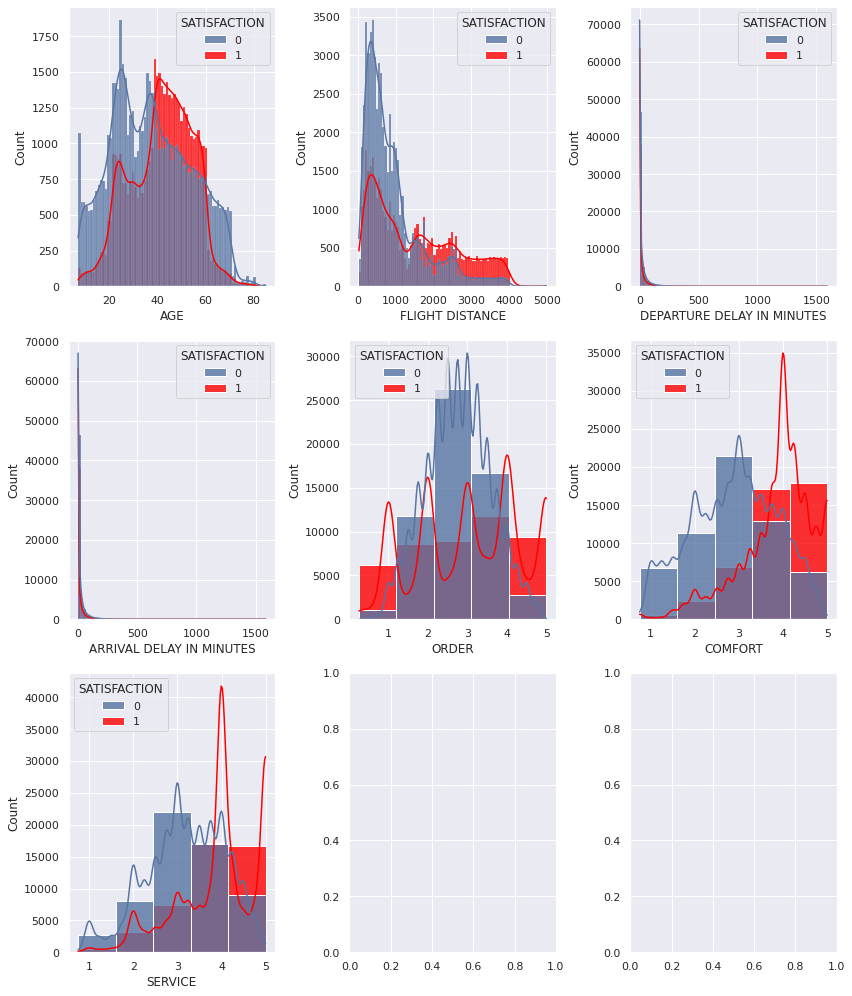

In [ ]:
numRows = 3
numColumns = 3
fig, axs = plt.subplots(numRows, numColumns)
for idx, feature in enumerate(continuous_features):
    if 'DELAY' in feature:
        bins=75
        sns.histplot(data=trainDf, x=feature,  ax=axs[idx//numColumns, idx%numColumns], palette=colourPalette[0:2], alpha=0.8, bins=bins, kde=True, hue='SATISFACTION')
    elif feature in {'ORDER', 'COMFORT', 'SERVICE'}:
        bins=5
        sns.histplot(data=trainDf, x=feature,  ax=axs[idx//numColumns, idx%numColumns], palette=colourPalette[0:2], alpha=0.8, bins=bins, kde=True, hue='SATISFACTION')
    else:
        sns.histplot(data=trainDf, x=feature,  ax=axs[idx//numColumns, idx%numColumns], palette=colourPalette[0:2], alpha=0.8, kde=True, hue='SATISFACTION')
    
fig.set_size_inches(12, 14)
plt.tight_layout()
plt.show()

- The AGE distribution shows a double peak along a larger volume of travellers between 20 and 60. Peaks are around the mid 20s and early 40s with a trough in the early 30s. The proportion of satisfied people increases with age up to around 60 years old when there is a sharp drop off. Perhaps there is a "too old for travelling" age...
- The FLIGHT DISTANCE distribution shows the majority of air travel distance is shorter than 1400 miles. There is a heavy skew towards the shorter distances. The greater the distance, the higher proportion of travellers indicate satisfaction vs non-satisfaction.
- Both DEPARTURE and ARRIVAL DELAY IN MINUTES show an uneven distribution towards the left of the graphs. Given their distributions we are likely going to have to transform or normalize these to improve their use in the feature set. 
- ORDER (which is an aggregated feature) shows a more or less even distribution when looking at the kde curve.
- Both COMFORT and SERVICE (also aggregated features) are skewed to the right.

Overall the distribution across Satisfied (1) and Unsatisfied (0) is reasonably well distributed, but we can appreciate that those who are rating 5 vs 0 are potentially going to have a more significant improvement in their overall satisfaction. 


#### Correlations

In [ ]:
trainDf.corrwith(trainDf['SATISFACTION']).drop('SATISFACTION').sort_values(ascending=False)

ONLINE BOARDING                      0.503447
CLASS                                0.494545
COMFORT                              0.475097
TYPE OF TRAVEL                       0.448995
INFLIGHT ENTERTAINMENT               0.398203
SERVICE                              0.367752
SEAT COMFORT                         0.349112
ON-BOARD SERVICE                     0.322450
LEG ROOM SERVICE                     0.313182
CLEANLINESS                          0.305050
FLIGHT DISTANCE                      0.298915
INFLIGHT WIFI SERVICE                0.284163
BAGGAGE HANDLING                     0.247819
INFLIGHT SERVICE                     0.244852
CHECKIN SERVICE                      0.235914
FOOD AND DRINK                       0.209659
CUSTOMER TYPE                        0.187558
EASE OF ONLINE BOOKING               0.171507
AGE                                  0.137040
ORDER                                0.126647
GATE LOCATION                        0.000449
GENDER                            

We notice there are no strong negative correlations with our target satisfaction, and there are a few features that have almost no correlation at all (i.e. GENDER and GATE LOCATION). Furthermore, we see the departure doesn't appear to have a large correlation with satisfaction, although this may be simply because of the current extremes. 

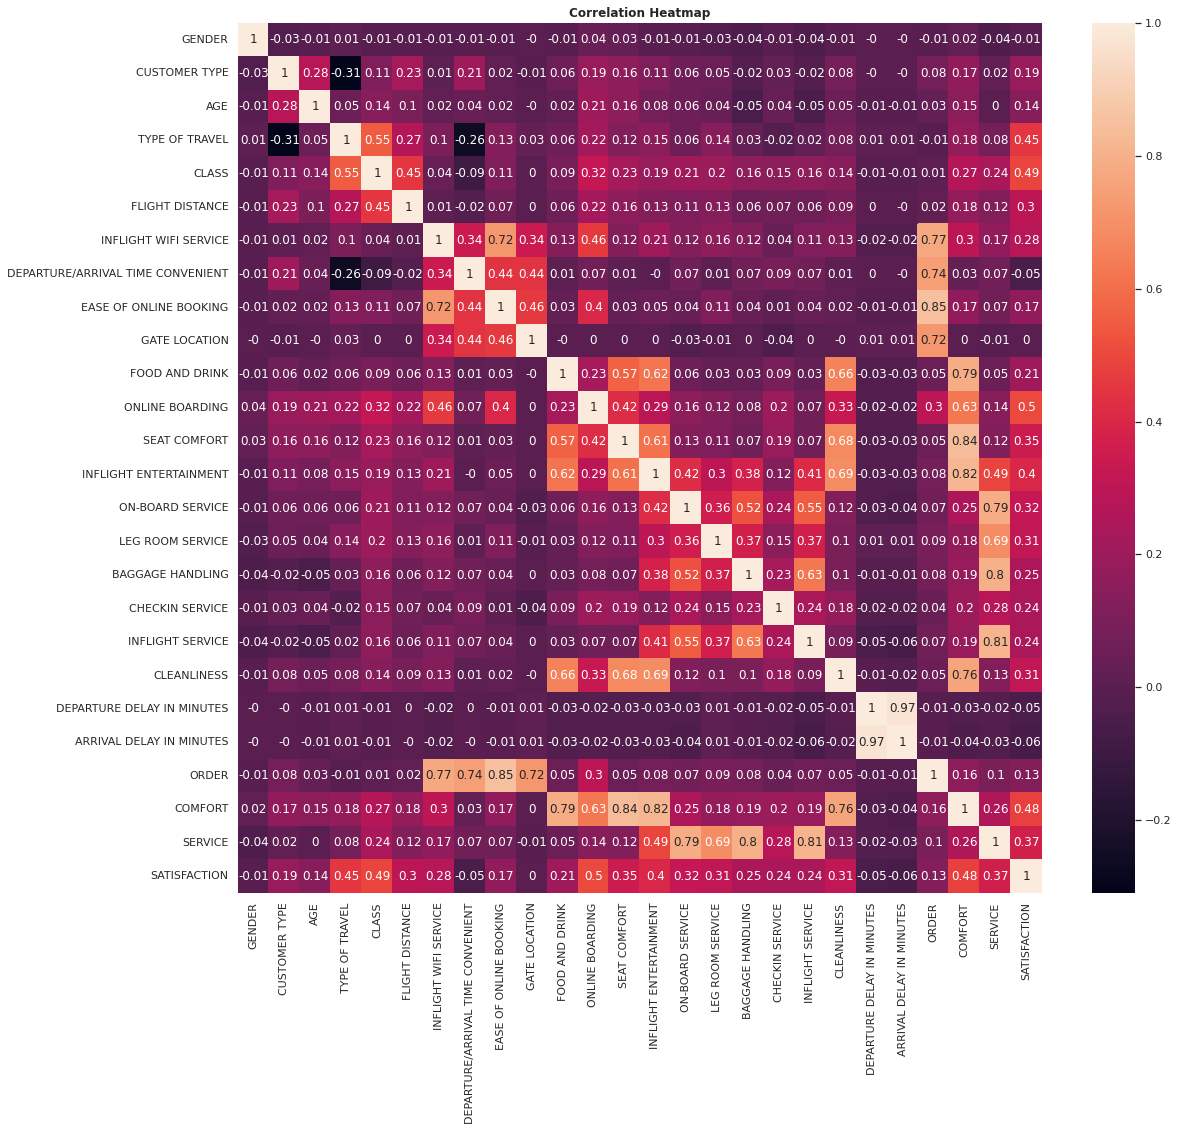

In [ ]:
corrMatrix = trainDf.corr().round(2)
# make the figure larger
_, ax = plt.subplots(figsize=(18,16))
sns.heatmap(data=corrMatrix, annot=True, ax=ax);
plt.title("Correlation Heatmap", weight='bold');

From the correlation matrix, we can see a number of features that have high correlation together, these could affect our model negatively if we chose to use these features together in our feature set. Examples include DEPARTURE DELAY IN MINUTES together with ARRIVAL DELAY IN MINUTES and a number of 'SERVICE' features. Rather than dropping these features from our table, we will attempt to transform this data and create a new feature that combines the data to make it usable without skewing the influence that the separated features would have on predicting satisfaction. 


Next, we further explore some relationships between variables of interest:

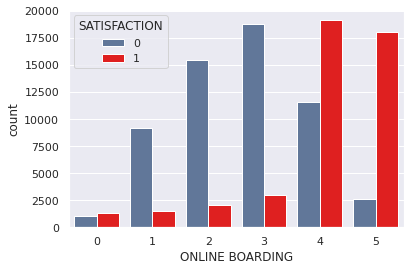

In [ ]:
sns.countplot(x='ONLINE BOARDING', palette=colourPalette, hue="SATISFACTION",data=trainDf);

The above plot shows that online boarding has a linear relation with satisfaction and more customer are satisfied with the increase in online boarding.

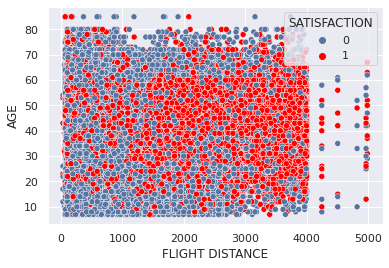

In [ ]:
sns.scatterplot(data=trainDf, x = 'FLIGHT DISTANCE', y = 'AGE', palette=colourPalette[0:2], hue="SATISFACTION");

The chart shows that as age tends towards the mid 40s and flight distance increases people are more satisfied. This combination of factors may indicate they would be good to use when predicting satisfaction, though they are not factors that are able to be influenced by the business - so if these features are used together they may hide the influence that other features that may be able to effect improvement on the business.

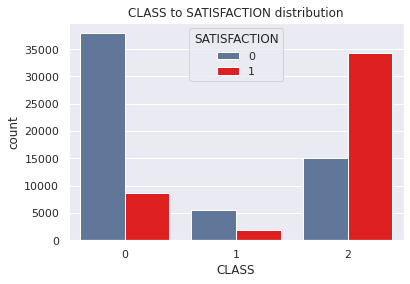

In [ ]:
sns.countplot(data=trainDf, palette=colourPalette, x='CLASS', hue="SATISFACTION", ).set(title="CLASS to SATISFACTION distribution");

We can see there is a strong bias towards dissatisfied customers within the eco plus class and maybe a heavily weighted identifier in our model. These results are not unsurprising given that those in the higher class would be more likely to have a better experience. The choice of whether to include this feature would depend on the outcome. For us to estimate Satisfaction it may be beneficial, but given how it could potentially weigh other features it may not be useful in every circumstance. If we wanted to examine how much changes in other features improve satisfaction overall, giving every customer first class is not exactly a reasonable rectification even if it makes the greatest difference.

## 1b) Metric Selection

**Potential Metrics** 

Initially, we listed all the potential metrics to assess the performance of our ML models.

Classification Report


---


*   Precision - How accurate our positive predictions are from those predicted
*   Recall - How many relevant predictions were found
*   F1-Score is a hybrid of precision and recall that will allow us to find a satisfactory medium.   
*   Accuracy - The overall performance of our model's ability to predict both True positive and true negatives

Others


---


*   Mean Squared Error - The square distance between our original values and our predicted values
*   R2 Score - How well our model fits our data

*   Confusion Matrix - A visualization we will use to compare the distribution of True/False Positives and Negatives (TP, TN, FP, FN) 
*   Categorical Cross Entropy - For Feed forward multi classes 
*   Binary Cross Entropy - For feed forward binary classes
*   Loss - For our feed forward network, measures how far the estimated value is from that of its predicted value. 



Since getting true positives and negatives are equally as important, we are going to focus mostly on **Accuracy**. The Accuracy of the algorithm using unseen data will be how we will measure our level of success as it aggregates TP, TN, FP, FN values. We established earlier that there is a slight imbalance between our classes, but it would not be considered a significant one like 1 sample per 10000 would be. Had our imbalances been more pronounced we would have opted for using the F1-score, given it takes into account false positives and negatives with more weight. Moreover, the problem domain doesn't involve a user-critical or life or death decision scenario, so a few erroneous false values won't be disastrous.

We do acknowledge that using accuracy alone we are not going to understand the breakdown of True and False Positives and True and False Negatives. The other metrics such as Precision, Recall and F1 score will better help identification of bias in training. So we are still using a Classification report for relevant metrics, as well as use potentially using a confusion matrix to visualise our distributions. These may highlight some issues we have not currently anticipated. But accuracy will be the consistent medium used for comparing how our models perform.
For our Feed Forward Neural Network, we will be using Binary Cross Entropy/Log loss as our chosen metric. This is because our target is categorically binary 0 for Dissatisfied and 1 for Satisfied. This metric will compare its predictions to the classes and penalize them based on their distances. We will also look at the loss function as it will give us an idea of the difference between our predicted values and the probability that they belong to the predicted class.

As a final metric, we have created a timer class just to run alongside our model creation, fit and predictions to assist in finding the sweet spot for evaluation. As there is no point in developing a 100% accurate model if it is going to take significant time and resources to compute when a slightly less accurate model can be done in a fraction of the time.

## 1c) Data Preparation

Here we conduct two main activities: 

- Pre-processing the data, with the aim of performing some normalisation of features that were found to present anomalies in the previous sections

- Partitioning the data for training and evaluation.

### **Data pre-processing**

We sample together both the DEPARTURE DELAY IN MINUTES and ARRIVAL DELAY IN MINUTES and then put those features into buckets that match our standard scale.

We further combine and take an average of particular service features that had high correlations with each other, such as 'SERVICE', 'INFLIGHT SERVICE','ON-BOARD SERVICE', 'LEG ROOM SERVICE' and 'BAGGAGE HANDLING'

This gives us two new features 'TOTALDELAY' and 'AVERAGESERVICE'

For our models, we are going to drop the aggregate features, but we will drop them after the split so we only have to do that once as we also still want to test the unchanged one.

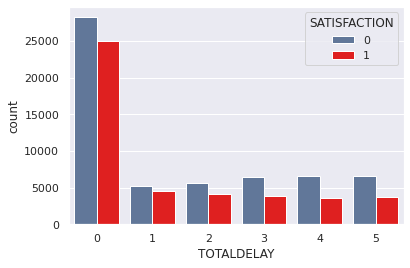

In [ ]:
#@title Must Run to create our Total Delay feature
#Try grouping together some values 
trainDf['TOTALDELAY'] = pd.qcut(trainDf['DEPARTURE DELAY IN MINUTES'] + trainDf['ARRIVAL DELAY IN MINUTES'], 10, labels=list(range(0,6)), duplicates="drop")
sns.countplot(data=trainDf, x='TOTALDELAY', palette=colourPalette, hue="SATISFACTION");

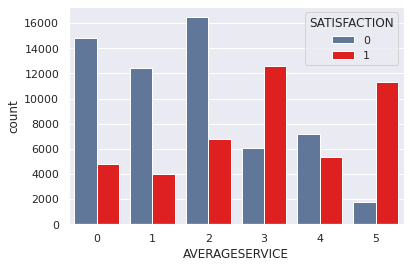

In [ ]:
#@title Must Run to create our Average Service Feature
serviceDf = trainDf[['SERVICE', 'INFLIGHT SERVICE','ON-BOARD SERVICE', 'LEG ROOM SERVICE', 'BAGGAGE HANDLING']]
trainDf['AVERAGESERVICE'] = pd.qcut((serviceDf.sum(axis=1))/len(serviceDf.columns), 6, labels=list(range(0,6)), duplicates="drop")
sns.countplot(x='AVERAGESERVICE',palette=colourPalette, hue="SATISFACTION",data=trainDf);



In [ ]:
#@title Must Run to create the features on the test set
# As above we do the same for our test set so that we do not have missing labels
testServiceDf = testDf[['SERVICE', 'INFLIGHT SERVICE','ON-BOARD SERVICE', 'LEG ROOM SERVICE', 'BAGGAGE HANDLING']]
testDf['TOTALDELAY'] = pd.qcut(testDf['DEPARTURE DELAY IN MINUTES'] + testDf['ARRIVAL DELAY IN MINUTES'],10 , labels=list(range(0,6)), duplicates="drop")
testDf['AVERAGESERVICE'] = pd.qcut((serviceDf.sum(axis=1))/len(serviceDf.columns), 6, labels=list(range(0,6)), duplicates="drop")

#Finally drop the unused features as we will no longer be including them in our feature set
# trainDf =  trainDf.drop(['SERVICE', 'INFLIGHT SERVICE','ON-BOARD SERVICE', 'LEG ROOM SERVICE', 'BAGGAGE HANDLING', 'DEPARTURE DELAY IN MINUTES', 'ARRIVAL DELAY IN MINUTES' ], axis=1)
testDf =  testDf.drop(['SERVICE', 'INFLIGHT SERVICE','ON-BOARD SERVICE', 'LEG ROOM SERVICE', 'BAGGAGE HANDLING', 'DEPARTURE DELAY IN MINUTES', 'ARRIVAL DELAY IN MINUTES' ], axis=1)


### **Data Partitioning**

In the following sections, we will build and compare the performance of various ML models, in an attempt to select the best one for the task at hand. We initially have 2 datasets, one for model training, and one for testing. For model selection, however, it is necessary to further partition the data, as it is important to make sure that the test dataset is not used for model selection or hyper-parameter tuning to avoid bias/overfit.

The two initial datasets a contain large number of samples for training and evaluating the various ML models. Specifically, the original training dataset contains 103594 samples, and the original test dataset contains 25893 samples. This amount of data provides an opportunity to use a three-way split (train/dev/test) to conduct initial model training and evaluation, so we will use this strategy.

However, as it will be seen later, once the best candidate emerges from the model selection process, we conduct a final hyperparameter tuning phase on the best performing model, for which we use cross-validation (leveraging Scikit-learn's GridSearchCV functionality).

In this section, though, we focus on performing the initial split. Specifically, the **original training set** will be further split into two: X_train (containing 90% of the training samples), and X_test (containing 10% of the training samples). The original testDf (our master test set) will remain untouched. Additionally, when splitting, since the target variable is slightly imbalanced towards '0' (i.e. Neutral or Dissatisfied), we will use stratification on the target variable to ensure an even distribution.


In [ ]:
#@title Must Run to create our split features
X_train, X_test, Y_train, Y_test = train_test_split(trainDf.drop('SATISFACTION', axis=1), trainDf['SATISFACTION'], stratify=trainDf['SATISFACTION'], test_size = 0.1, random_state=1234)

# As part of our preprocessing we are dropping these columns here as to not have to split more than once
# This set is just the control 
non_Transformed_X_train = X_train.drop(['TOTALDELAY', 'AVERAGESERVICE'], axis=1) 
non_Transformed_X_test = X_test.drop(['TOTALDELAY', 'AVERAGESERVICE'], axis=1) 

# This set is the one we'll be using as a majority that includes total delay and average service which are the aggregates of those we remove
X_train = X_train.drop(['SERVICE', 'INFLIGHT SERVICE','ON-BOARD SERVICE', 'LEG ROOM SERVICE', 'BAGGAGE HANDLING', 'DEPARTURE DELAY IN MINUTES', 'ARRIVAL DELAY IN MINUTES' ], axis=1)
X_test =  X_test.drop(['SERVICE', 'INFLIGHT SERVICE','ON-BOARD SERVICE', 'LEG ROOM SERVICE', 'BAGGAGE HANDLING', 'DEPARTURE DELAY IN MINUTES', 'ARRIVAL DELAY IN MINUTES' ], axis=1)

print(f'X_train = {X_train.shape}')
print(f'Y_train = {Y_train.shape}')
print(f'X_test = {X_test.shape}')
print(f'Y_test = {Y_test.shape}')

X_train = (93234, 20)
Y_train = (93234,)
X_test = (10360, 20)
Y_test = (10360,)


Whilst it is expected that a 90%/10% split is enough to guarantee similar distributions between the training and dev datasets above (remembering here 'testing' refers to our 'devevelopment' dataset), it is better to visualise this to ensure that is the case.

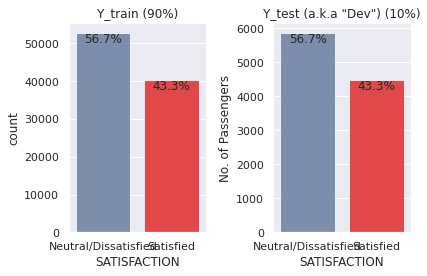

In [ ]:
fig, ax = plt.subplots(1, 2)

sns.countplot(data=Y_train.to_frame(), x='SATISFACTION', palette=colourPalette, alpha=0.8, ax=ax[0]);
ax[0].set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
plotWithPercentage(ax[0], float(len(Y_train)))
plt.ylabel('No. of Passengers')
ax[0].title.set_text('Y_train (90%)')

sns.countplot(data=Y_test.to_frame(), x='SATISFACTION', palette=colourPalette, alpha=0.8, ax=ax[1]);
ax[1].set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
plotWithPercentage(ax[1], float(len(Y_test)))
plt.ylabel('No. of Passengers')
ax[1].title.set_text('Y_test (a.k.a "Dev") (10%)')

plt.tight_layout()
sns.set(rc={'figure.figsize':(8,6)})
plt.show()

It is clear that both Y_train and Y_test (our __dev__) dataset have equivalent distributions.

Although we are satisfied at this point our split has not negatively affected our distribution, we are going to run a learning curve once we have established a baseline model to ascertain this. This will give us a better identifier of how increased data affects the over/underfit of the model. We will also need to consider whether the split is large enough that it would introduce bias towards predicting Dissatisfaction. We will therefore also trial with a cross validation training distribution to see if that model will perform better.

We can now proceed to model training and selection.

# 2. Logistic Regression Model

### 2a) Feature Selection

After understanding and performing transformations of our data, we then look at building a Logistic Regression model. We test out different feature sets, and attempt to evaluate different models incrementally:

1.   Without our input or selections on the original set.
2.   With our new transformed dataset removing unnecessary columns.
3.   With our intuitive features, features that made logical sense and were not highly correlative.
4.   Greedy Selection of features, those which impacted the model the most would be added incrementally.
5.   Scikit-learn Feature Selection tools (RFE, Sequential Feature Selector and PCA).

As we will see, the initial unadulterated model accuracy (step 1 above) was not too far (performance-wise) from the subsequent models. However, the duration to train and predict was rather significant.  We felt we could do better by eliminating features that may negatively impact the model and hopefully get a more accurate and faster processed model. This was done systematically through the use of multiple trials of Recursive feature elimination, Greedy Feature Selection, Scikit-Learn's SelectFromModel and PCA. Mapping the number of features to the overall quality of our model error helped us establish a sweet spot for the number of features.

We use the 90/10 split (train/dev) generated above and compare across the various forms of Logistic Regression being incrementally examined, based on the accuracy metric selected previously, for both the Training Set and Dev Sets. A timer will also be run to establish how long it takes.



#### 1. Original Feature Set 

We analyse how the model performs on the original full feature set with nothing excluded. Overall it performs pretty well with reasonable accuracy, precision recall and f1 score. Unfortunately including so many features in our model can cause the fit time to be more significant and take longer to predict our results. For a quicker application if we were to use a continuous data set this would likely become impractical and not efficient enough.

Note: for using the original dataset we had to increase our max iterations up significantly to give it a better result. By default was giving us a high bias underfit model.

In [ ]:
# Original Data that has not been transformed we remove the target and the additional new features
originalTrainDfCols = non_Transformed_X_train.columns

originalAccuracy, originalTestAccuracy, originalDuration = trainPrintAndReturnMetric(originalTrainDfCols, non_Transformed_X_train, non_Transformed_X_test, Y_train, Y_test)


**Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)**
Number of features: 25


Training Classification Results
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     52827
           1       0.87      0.84      0.85     40407

    accuracy                           0.88     93234
   macro avg       0.87      0.87      0.87     93234
weighted avg       0.88      0.88      0.88     93234


Dev Classification Results
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      5870
           1       0.86      0.83      0.85      4490

    accuracy                           0.87     10360
   macro avg       0.87      0.8

We next explore what the learning curve looks like on the baseline (unoptimised) model, and the original (full-feature) training dataset, to have an idea of the impact of adding/reducing samples when training data, and at which point(s) we may start seeing a high bias or variance problem.

***
Learning curve for Pipeline(memory=None,
         steps=[('logistic_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
***


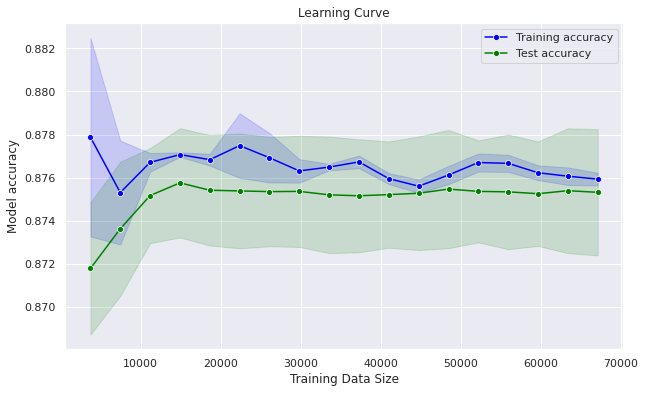

In [ ]:
# Warning this takes about 10-15 mins to run
logRegUnoptimisedPipeline = Pipeline(steps=[('logistic_reg', LogisticRegression(max_iter=10000))])
plot_learning_curve(logRegUnoptimisedPipeline, non_Transformed_X_train, Y_train)

With a baseline (unoptimised) Logistic Regression model trained on the original (non-transformed) training data, the model shows that with under ~5000 samples there is high bias (as the test accuracy is markedly lower when compared to the training dataset). Then, as more data is added, test accuracy improves reaching a peak at around 15000  samples. However, at this point, there also appears to be a wider gap between training and test data, when compared with other areas of the chart, suggesting higher-than-ideal bias. As more samples are added, the test accuracy seems to level out, and at around 45000 samples, we have a 'sweet' spot, where the gap between training and test performance is minimal.

From this, we can infer that the baseline model wouldn't necessarily benefit from additional training samples after the ~45000 mark. However, adding more samples doesn't seem to be detrimental either, as the test accuracy remains at a plateau as more data is added. Also, as we approach the largest training data sizes (>65000), there is no apparent increased risk of overfitting or underfitting. In consequence, since we are yet to conduct model tuning and feature selection activities, we consider that keeping our current 90% vs 10% split for training and test (dev) data is desirable, as we would like to keep the highest possible amount of training data available for subsequent models to learn from.

We can also use this unoptimised model to set a goal for our optimised model. Since the unoptimised model is able to achieve a prediction accuracy of around 0.876 (87.6% correct, a 12.4% error rate) we should be aiming for an optimised model to be able to at least halve the error rate. Our goal will therefore be to achieve a prediction accuracy of 0.94 (94% correct, reducing the error rate to 6%) on the same data (test data).

#### 2. Transformed data set

Exploring the model performance on our transformed dataframe with all the features, we find that our model is improved slightly. 

In [ ]:
# Feature selection removing the combined features we no longer need for this transformation as they have been combined
transformedTrainDFCols = X_train.columns
transformedAccuracy, transformedTestAccuracy, transformedDuration =  trainPrintAndReturnMetric(transformedTrainDFCols, X_train, X_test, Y_train, Y_test)


**Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)**
Number of features: 20


Training Classification Results
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     52827
           1       0.87      0.84      0.86     40407

    accuracy                           0.88     93234
   macro avg       0.88      0.87      0.88     93234
weighted avg       0.88      0.88      0.88     93234


Dev Classification Results
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5870
           1       0.86      0.84      0.85      4490

    accuracy                           0.87     10360
   macro avg       0.87      0.8

#### 3. Logically Filtered intuitive features excluding transformed data

In an attempt to manually optimise the LR model, we each chose a set of features that felt could be good candidates in order to reduce the feature size of the model. The code below runs through the set of choices we all chose initially, an educated guess if you will, based on aspects such as intra-feature correlations or feature variance. We have taken the highest score to compare later. The scores were pretty consistent but didn't really improve significantly over the general all feature model. However, it is worth mentioning that the reduced number of features will allow the model to train faster. We had examined the classification matrix for these results, but have omitted it for brevity as they take up considerable space. 

In [ ]:
BenChoice = ['SEAT COMFORT', 'ONLINE BOARDING', 'INFLIGHT ENTERTAINMENT', 'BAGGAGE HANDLING']
BiJayChoice = ["ARRIVAL DELAY IN MINUTES","TYPE OF TRAVEL", "SERVICE", "ONLINE BOARDING", "CLASS", "COMFORT"]
# These are just based on high correlation features
RobChoice = ['ONLINE BOARDING', 'CLASS', 'COMFORT', 'TYPE OF TRAVEL', 'INFLIGHT ENTERTAINMENT', 'SERVICE', 'CLEANLINESS']
# Selecting based on top 5 high correlating features, and some features with lowest variance.
LibardoChoice = ['ONLINE BOARDING', 'CLASS', 'COMFORT', 'TYPE OF TRAVEL', 'INFLIGHT ENTERTAINMENT', 'CUSTOMER TYPE', 'GENDER', 'SERVICE', 'ORDER']

intuitiveFeatureTestBestScore = 0
intuitiveFeatureBestScore = 0
intuitiveFeaturesDuration = 80000
ourIndividualScoresLabel = ["Ben", "Bijay", "Rob", "Libardo"]
individualScores = []
individualTimes = []

for setOfChoices in [BenChoice, BiJayChoice, RobChoice, LibardoChoice]:
    currentAccuracy, currentTestAccuracy, currentDuration = trainPrintAndReturnMetric(setOfChoices, non_Transformed_X_train, non_Transformed_X_test, Y_train, Y_test)  
    individualScores.append(currentTestAccuracy)
    individualTimes.append(currentDuration)
    

    if currentTestAccuracy > intuitiveFeatureTestBestScore:
        intuitiveFeatureBestScore = currentAccuracy
        intuitiveFeatureTestBestScore = currentTestAccuracy
        intuitiveFeaturesDuration = currentDuration

# Turn it all into a dataframe for easy plotting
ourDf = pd.DataFrame()
ourDf['NAMES'] = ourIndividualScoresLabel
ourDf['ACCURACY'] = individualScores
ourDf['TIME SECONDS'] = individualTimes



**Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)**
Number of features: 4


Training Classification Results
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     52827
           1       0.78      0.76      0.77     40407

    accuracy                           0.80     93234
   macro avg       0.80      0.80      0.80     93234
weighted avg       0.80      0.80      0.80     93234


Dev Classification Results
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      5870
           1       0.78      0.77      0.77      4490

    accuracy                           0.80     10360
   macro avg       0.80      0.80

NAMES  ACCURACY  TIME SECONDS
0      Ben     0.804           0.3
1    Bijay     0.843           0.9
2      Rob     0.846           0.5
3  Libardo     0.854           0.7

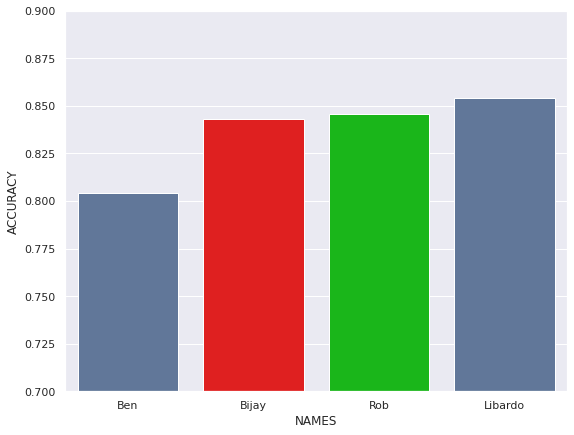

In [ ]:
# Plotting our initial test features against accuracy 
sns.set(rc={'figure.figsize':(9,7)})
sns.barplot(data=ourDf,x='NAMES', y='ACCURACY', palette=colourPalette).set(ylim=(.7,0.9))
ourDf

These results are not a reflection of individual choices, but likely represent a relationship between accuracy and number of features chosen. Ben, whose feature set was the smallest, clearly operates significantly faster but is less accurate. The time required to train the model is not excessive so using more features seems to be the better choice.

#### 4. Greedy feature Selection
The code for determining greedyFeatures is omitted and in the Appendix as it takes a while to run, but overall gave unsatisfying results, but did give us a good convergence on test and train scores.

In [ ]:
# These features were gathered by running a greedy algorithm (See appendix) on the original data frame and taking whatever immproved the model enough to the point it didn't increase by more than a percent
greedyFeatures = ["SERVICE", "ONLINE BOARDING", "TYPE OF TRAVEL", "CHECKIN SERVICE", "INFLIGHT WIFI SERVICE", "DEPARTURE/ARRIVAL TIME CONVENIENT", "CLASS", "CLEANLINESS"]
greedyAccuracy, greedyTestAccuracy, greedyDuration = trainPrintAndReturnMetric(greedyFeatures, non_Transformed_X_train, non_Transformed_X_test, Y_train, Y_test)


**Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)**
Number of features: 8


Training Classification Results
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     52827
           1       0.84      0.82      0.83     40407

    accuracy                           0.85     93234
   macro avg       0.85      0.85      0.85     93234
weighted avg       0.85      0.85      0.85     93234


Dev Classification Results
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      5870
           1       0.84      0.83      0.83      4490

    accuracy                           0.85     10360
   macro avg       0.85      0.85

#### 5. Scikit-Learn Feature Selection tools

##### Recursive Feature Elimination

The RFE function is very time consuming and we have recorded the results here to reduce the time taken for the above code to work. For the interested reader, the code we used to run this is in the Appendix. This was run on the Dataframe with the transformed data set.

For instance, RFE identified the following:

**Top 3 features:** ['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'AVERAGESERVICE']  

**Top 5 features:** ['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING', 'TOTALDELAY',
       'AVERAGESERVICE']  

**Top 10 features:** ['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'TOTALDELAY', 'AVERAGESERVICE']  

The remainder of the output has been entered in the Appendix under RFE results and the resulting scores are shown in the below code block. The errors are charted against the number of features.


In [ ]:
f1Score = [0, 0.6752671279586494, 0.7749023800819914, 0.8093746709673848, 0.8612607336064159, 0.8624397559992003, 0.866044968388698, 0.8664496888387814, 0.8713633558792351, 0.8717506783928715, 0.8740912968919947, 0.874555024625628, 0.8748140938388548, 0.8746481628618015, 0.8745651751541109, 0.8748016205202745, 0.8746821586334107, 0.8746699482543889, 0.8746927187187995, 0.874888578115945]
accuracies = [0, 0.6802025012334556, 0.7756505137610743, 0.8124074908295257, 0.863665615547976, 0.8656176931162451, 0.8692966085333677, 0.869747087972199, 0.8742626080614369, 0.8746701846965699, 0.8769225818907266, 0.8773408842267842, 0.8776090267498982, 0.8774588669369543, 0.8773837870304825, 0.8776197524508227, 0.8775017697406525, 0.877491044039728, 0.8775124954415771, 0.8777055580582191]
mserrors = [0, 0.3197974987665444, 0.22434948623892573, 0.1875925091704743, 0.13633438445202395, 0.13438230688375485, 0.13070339146663235, 0.130252912027801, 0.12573739193856318, 0.12532981530343007, 0.12307741810927345, 0.12265911577321578, 0.1223909732501019, 0.12254113306304568, 0.12261621296951755, 0.12238024754917734, 0.12249823025934745, 0.122508955960272, 0.12248750455842289, 0.1222944419417809]
r2Score = [0, -0.3023003012045098, 0.08638934128338027, 0.2360735085837511, 0.4448101982623247, 0.45275957627477514, 0.46774109637516237, 0.46957556822418944, 0.48796396461562686, 0.4896237248599846, 0.49879608410511966, 0.5004995222506448, 0.5015914697798276, 0.5009799791634852, 0.5006742338553141, 0.5016351476809948, 0.5011546907681544, 0.5011110128669871, 0.5011983686693218, 0.5019845708903333]

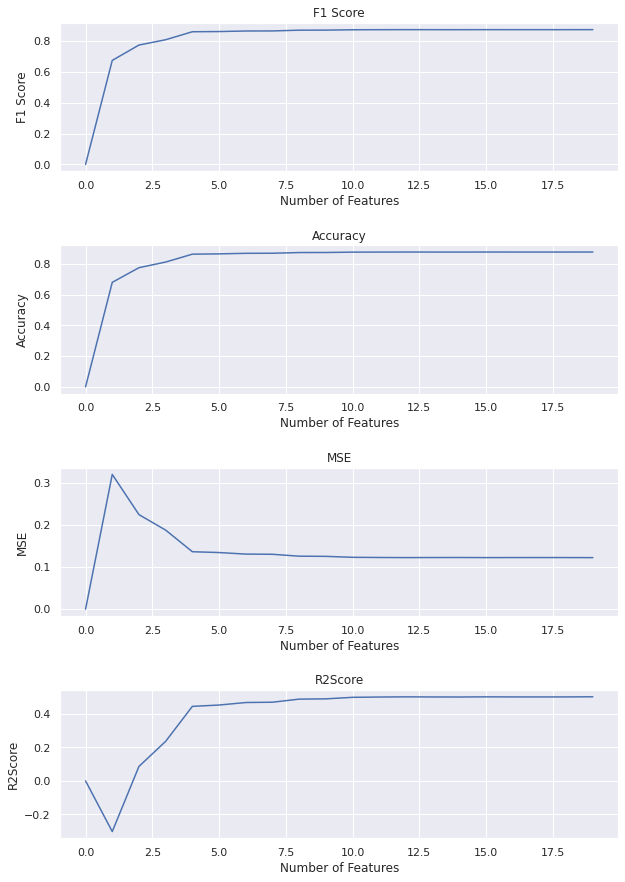

In [ ]:
#Plotting the scores on the map
plots = plt.figure(figsize=(10,15))
plots.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
labels = ["F1 Score", "Accuracy", "MSE", "R2Score"]

for idx, metric in enumerate([f1Score, accuracies, mserrors, r2Score]):
    plt.subplot(4,1,idx+1)
    plt.xlabel("Number of Features")
    plt.ylabel(labels[idx])
    plt.title(labels[idx])
    sns.lineplot(data=metric)

This shows us that the Accuracy and F1 score begin to top out around 5 chosen features but still slightly improve minimally, and the remaining metrics of R2 and MSE don't level out until around 10 so with that in mind we try our model on the top 10 chosen. 

In [ ]:
# These are the top 10 features determined by the recursive feature elimination method
top10RFE = ['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'TOTALDELAY', 'AVERAGESERVICE']

rfeAccuracy, rfeTestAccuracy, rfeDuration = trainPrintAndReturnMetric(top10RFE, X_train, X_test, Y_train, Y_test)  


**Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)**
Number of features: 10


Training Classification Results
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     52827
           1       0.87      0.84      0.86     40407

    accuracy                           0.88     93234
   macro avg       0.88      0.87      0.88     93234
weighted avg       0.88      0.88      0.88     93234


Dev Classification Results
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5870
           1       0.86      0.84      0.85      4490

    accuracy                           0.87     10360
   macro avg       0.87      0.8

##### SequentialFeatureSelector

The SFS function is very time consuming (it took more than 20 minutes to run). The results were only imported here to reduce the time taken for the SFS code to work. The code that was used to run this is in the Appendix. This is run on the dataframe with the transformed data set.

In [ ]:
# Top 10 features identified by SFS
top10SFS = ['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'ONLINE BOARDING', 'CHECKIN SERVICE', 'CLEANLINESS', 'ORDER',
       'TOTALDELAY', 'AVERAGESERVICE']

sfsAccuracy, sfsTestAccuracy, sfsDuration = trainPrintAndReturnMetric(top10SFS, X_train, X_test, Y_train, Y_test)  


**Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)**
Number of features: 10


Training Classification Results
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     52827
           1       0.87      0.84      0.86     40407

    accuracy                           0.88     93234
   macro avg       0.88      0.87      0.87     93234
weighted avg       0.88      0.88      0.88     93234


Dev Classification Results
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5870
           1       0.86      0.84      0.85      4490

    accuracy                           0.87     10360
   macro avg       0.87      0.8

##### Principal Component Analysis (PCA)

We also explored PCA as a method to reduce the high-dimensionality of the feature-set. Here we use GridSearchCV to automatically find the best value for the 'n_components' parameter of the PCA() function in Scikit-Learn. The pipeline also contains a StandardScaler() step, since PCA works best when data has been normalised.

In [ ]:
pca_pipeline = Pipeline(steps=[('standard_scaler', StandardScaler()), 
                               ('pca', PCA()), 
                               ('logistic_reg', LogisticRegression())])

pca_pipeline_params = {
    'pca__n_components': range(10, len(X_train.columns)+1)
}

In [ ]:
hyperparameter_tuning(pca_pipeline, pca_pipeline_params, X_train, Y_train, X_test, Y_test)

Fitting 4 folds for each of 11 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   12.5s finished


***
Hyperparameter tuning for Pipeline(memory=None,
         steps=[('standard_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

The best parameters found were: {'pca__n_components': 18}
***


From above, we can see that the best value for the n_components parameter in PCA is 18. We now proceed to train a model with this parameter and produce the result metrics for comparison later.

In [ ]:
PCATunedLRModel = Pipeline(steps=[('standard_scaler', StandardScaler()),
                                         ('pca', PCA(n_components=18)),
                                         ('logistic_reg', LogisticRegression())])

PCATunedLRAccuracy, PCATunedLRTestAccuracy, PCATunedLRDuration = trainPrintAndReturnMetric(X_train.columns, X_train, X_test, Y_train, Y_test, model=PCATunedLRModel)


**Model: Pipeline(memory=None,
         steps=[('standard_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=18,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)**
Number of features: 20


Training Classification Results
              precision    recall  f1-score   support

### 2b) Hyper Parameter tuning our best Features

Now that we have been able to determine the top 10 features through Recursive Feature Elimination, we want to see if we can improve the model any via hyper parameter tuning.  We do this using GridSearchCV and used a CV of 5 to make sure we had a nice distribution of data across each test. We tested the C parameter for values between 0.1 and 3 in increments of 0.1 which as demonstrated below got 'worse' but not notably so. The mean score remained essentially unchanged.

In [ ]:
# Our best model features
bestModelFeatures = ['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'TOTALDELAY', 'AVERAGESERVICE']

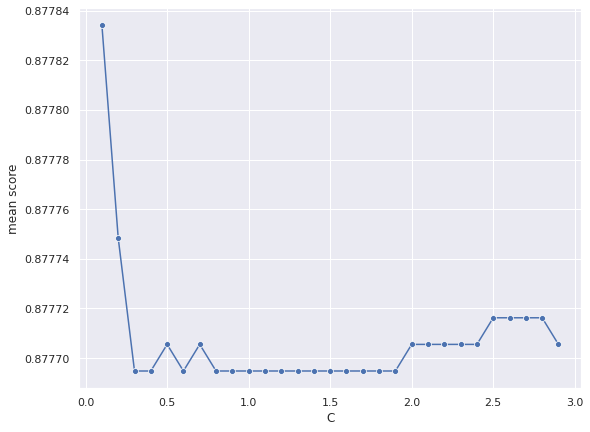

In [ ]:
# give us a range of C values to test
c = np.arange(0.1,3.0,0.1)
bestFeaturesTunedLRModel = GridSearchCV(LogisticRegression(), param_grid={'C':c}, cv=5)
t = Timer()
t.start()
bestFeaturesTunedLRModel.fit(X_train[bestModelFeatures], Y_train)
y_pred_train = bestFeaturesTunedLRModel.predict(X_train[bestModelFeatures])
y_pred_test = bestFeaturesTunedLRModel.predict(X_test[bestModelFeatures])
hyperBestDuration = t.stop()

meanTestScore = bestFeaturesTunedLRModel.cv_results_['mean_test_score']
scores_df = pd.DataFrame.from_records(zip(c,meanTestScore), columns=['C','mean score'])
sns.lineplot(data=scores_df, x='C', y='mean score', marker='o');

This shows us that the C parameter isn't really any benefit to us and anything over 1 (default) just decreased the accuracy. Even the top of our chart from 0.1 is a fraction change

In [ ]:
# We have done this just to time the set of features with the found hyper perameters, we don't expect much of a change but using it with grid will only test how long it takes to tune 
hyperBestaccuracy, hyperBestTestAccuracy, hyperBestDuration = trainPrintAndReturnMetric(bestModelFeatures, X_train, X_test, Y_train, Y_test, metric='accuracy', C=bestFeaturesTunedLRModel.best_params_['C'])


**Model: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)**
Number of features: 10


Training Classification Results
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     52827
           1       0.87      0.84      0.86     40407

    accuracy                           0.88     93234
   macro avg       0.88      0.87      0.87     93234
weighted avg       0.88      0.88      0.88     93234


Dev Classification Results
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5870
           1       0.86      0.84      0.85      4490

    accuracy                           0.87     10360
   macro avg       0.87      0

### 2c) Evaluation and Summary


#### Comparing our models

Using the data we gathered from our model performance calculations, we can compare the different feature sets on our model accuracy on their respective test data (the dev dataset):

Accuracy comparison amongst various Feature Selection strategies



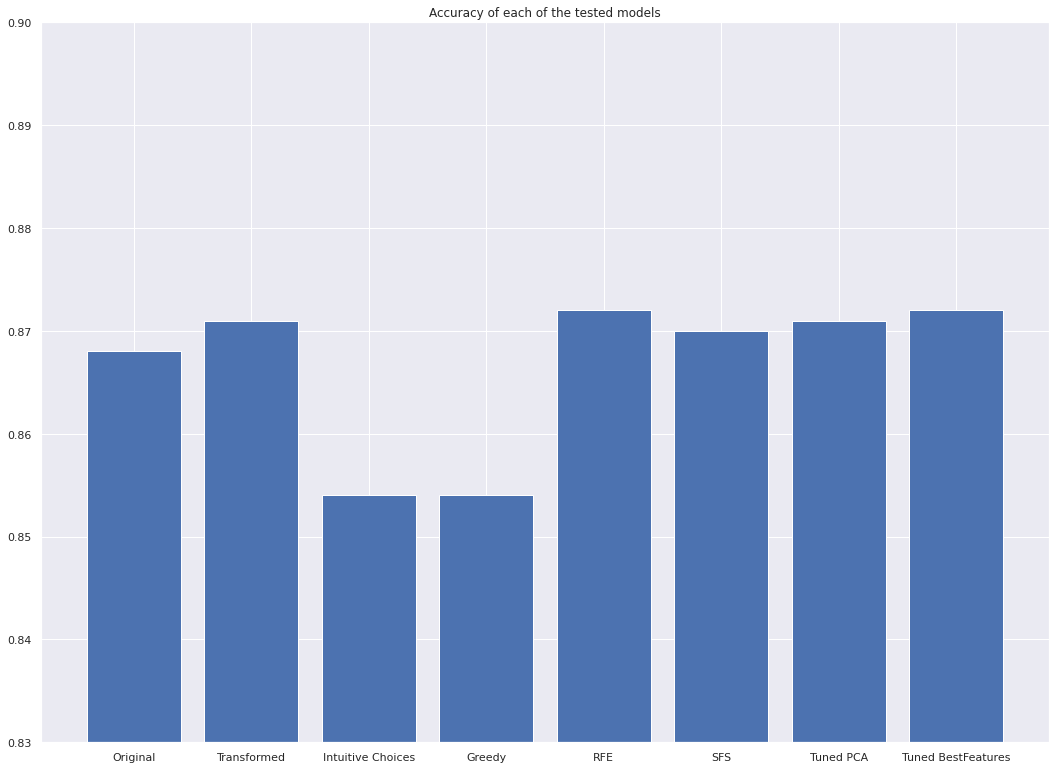

In [ ]:
print("Accuracy comparison amongst various Feature Selection strategies\n")
comparisonFigure = plt.figure(figsize=(14,10))

ax = comparisonFigure.add_axes([0,0,1,1])
modelLabels = ['Original', 'Transformed', 'Intuitive Choices', 'Greedy', 'RFE', 'SFS', 'Tuned PCA', 'Tuned BestFeatures']
scores = [originalTestAccuracy,transformedTestAccuracy,intuitiveFeatureTestBestScore,greedyTestAccuracy,rfeTestAccuracy, sfsTestAccuracy, PCATunedLRTestAccuracy, hyperBestTestAccuracy]

ax.bar(modelLabels,scores)
ax.set_title("Accuracy of each of the tested models")
plt.ylim([0.83, 0.90])
plt.show()

Our chart above illustrates that overall there wasn't a significant change across the board, infact very little was gained over the transformed featureset with regards to accuracy. 

In [ ]:
LRModelComparisonDf = pd.DataFrame(data=scores, index=modelLabels, columns=['LR Model performance'])
LRModelComparisonDf.sort_values('LR Model performance', ascending=False)

LR Model performance
RFE                                0.872
Tuned BestFeatures                 0.872
Transformed                        0.871
Tuned PCA                          0.871
SFS                                0.870
Original                           0.868
Intuitive Choices                  0.854
Greedy                             0.854

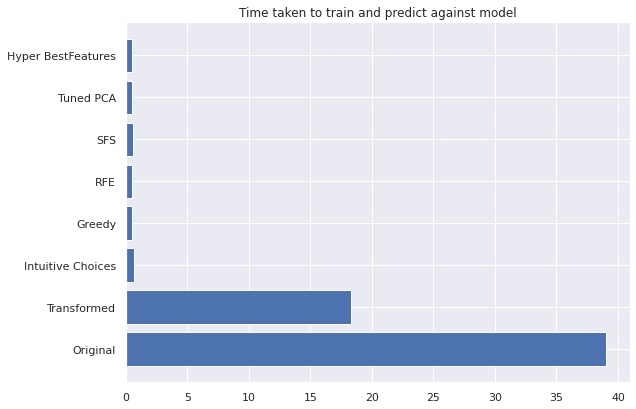

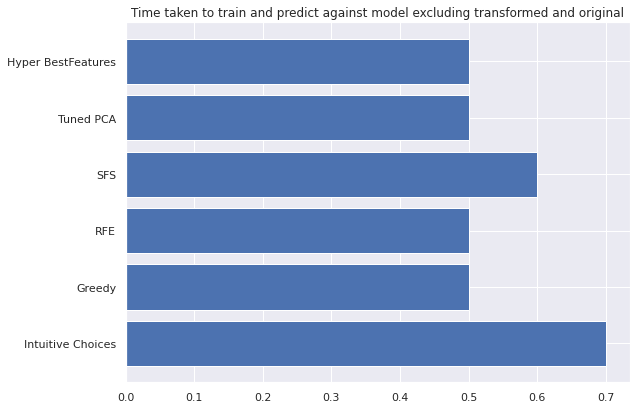

In [ ]:
comparisonFigure2 = plt.figure(figsize=(7,5))

ax = comparisonFigure2.add_axes([0,0,1,1])
modelLabels = ['Original', 'Transformed', 'Intuitive Choices', 'Greedy', 'RFE', 'SFS', 'Tuned PCA', 'Hyper BestFeatures']
scores = [originalDuration,transformedDuration,intuitiveFeaturesDuration,greedyDuration,rfeDuration, sfsDuration, PCATunedLRDuration, hyperBestDuration]

ax.barh(modelLabels,scores)
ax.set_title("Time taken to train and predict against model")

plt.show()

comparisonFigure3 = plt.figure(figsize=(7,5))

ax = comparisonFigure3.add_axes([0,0,1,1])
modelLabels = ['Intuitive Choices', 'Greedy', 'RFE', 'SFS', 'Tuned PCA', 'Hyper BestFeatures']
scores = [intuitiveFeaturesDuration,greedyDuration,rfeDuration, sfsDuration, PCATunedLRDuration, hyperBestDuration]

ax.barh(modelLabels,scores)
ax.set_title("Time taken to train and predict against model excluding transformed and original")

plt.show()

This is where our results from earlier really benefit from comparing our durations side by side. Although our transformed dataset was quite a satisfactory accuracy and very comparable to our other tuned models, it took well over 20X longer. But our clear winners with the reduced feature set was RFE and Tuned PCA

#### Evaluating best models against the Test Data

From the previous section, the best candidate Logistic Regression model (considering accuracy and time to train) is **bestFeaturesTunedLRModel**. This model was built by reducing the training data set features to the top 10 features that were found via RFE and then undergoing hyperparameter tuning to select the best value for the **C** parameter.

We now proceed to assess the model with the real test dataset, which up to this point has remained 'unseen' in the feature selection and hyperparameter tuning activities.

In [ ]:
# Predict on 'unseen' test data (master test dataset)
bestFeaturesTunedLRPredictions = bestFeaturesTunedLRModel.predict(testDf[bestModelFeatures])

# Print evaluation metrics
print("bestFeaturesTunedLR model:\n")
print(classification_report(testDf['SATISFACTION'], bestFeaturesTunedLRPredictions))

bestFeaturesTunedLR model:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     14528
           1       0.81      0.81      0.81     11365

    accuracy                           0.83     25893
   macro avg       0.83      0.83      0.83     25893
weighted avg       0.83      0.83      0.83     25893



In [ ]:
# Calculate model accuracy
bestLRModelAccuracy = accuracy_score(testDf['SATISFACTION'], bestFeaturesTunedLRPredictions).round(3)
print(f'Accuracy on test (unseen) data: {bestLRModelAccuracy}')

Accuracy on test (unseen) data: 0.832


#### Summary

In the previous sections, we attempted to obtain the best combination of features and hyper-parameters to come up with the most suitable Logistic Regression model for predicting Airline Satisfaction levels.
Initially, we set out to manually come up with the best possible features for the model. Then, since we wanted to employ a more systematic and evidence-based way of doing so, we tried many different feature selection tools provided by Scikit-Learn, including RFE, SFS and PCA. We found that different approaches led to slightly different results on the train/dev data, and also varying training times. Our results strongly identified using the original feature set in its entirety caused nearly a 100X increase in the duration of training. Depending on the application of this model this may be satisfactory as it was only under a minute, but if this was to be done on the fly with live input this could begin to create a strong backlog of data to be trained. We were satisfied that our learning curve identified our split wasn't negatively affecting our model, and as we have trained all models on the same split, it remained consistent.

A clear pattern that emerged was that selecting the right features can make a significant difference in both the time prediction times, as well as the overall accuracy. Decreasing the number of features reduces the amount of redundant data and decisions based on noise. Moreover, it also reduces the amount of data the model has to process which can make the prediction time a lot quicker. This shows that not all features are equal, and careful feature engineering can make a big difference between successfully and meaningfully modelling the problem. Removing less relevant features also seems to be beneficial to the performance of the model.

This was evidenced during the feature selection process using RFE, where we programmatically carried out tests over multiple numbers of features. In a way, this was an exercise of manual hyperparameter tuning the n_features parameter of the RFE algorithm. It was noticed that the accuracy stopped increasing after a certain number of feature selections. In consequence, we settled with the top 10 features suggested by RFE and moved on to carry automated hyper-parameter tuning work provided by GridSearchCV.
When we ran our GridSearch turning our hyperparameter C, we didn't obtain a notable result. We ensured to use a CV split to make sure that our Hyperparameter measurement was the average across our model to give us the best result. But as we identified earlier the result wasn't far off the default being 1, although our chart clearly showed it decreased from 0 and any increase offered reduced accuracy, we had to be mindful the change was a fraction of a percent and barely notable for the effort. This could potentially be attributed to it being a subset of a split such that the number of data points was reduced, but given the insignificance of change, likely it wasn't impactful overall.

When we evaluate our final model on the wild data known as testDf, we were given a pretty realistic estimate of the models' performance which was quite satisfactory. Although our predictions for our development test split lead us to believe we should be getting an accuracy closer to 87%, our completely independent results were 84% with all the precision-recall and F1 scores still having the same slight disparity between classes 0 and 1, which we did expect given the slight imbalance. We can acknowledge there may be a slight overfit towards the training data, but given the speed of the model, we were happy with the results.


# 3. Decision Tree Classifier



## 3a) Data Preparation

The same training, development and test data created during the data preparation phase will be used to train, tune and test the Decision Tree Classifier. Training and assessing model performance on the same data will allow us to compare models trained on a like-for-like basis, and give us increased confidence when making recommendations. Please view the [data preparation phase](`https://colab.research.google.com/drive/1jc7jpVnR6NNe7JQRPCk-fVcOQiTx52f1?authuser=1#scrollTo=1c_Data_Preparation`) section for detailed data split process.



We can trial our Decision tree on the full feature set, decision trees can be less particular regardings features

## 3b) Training


Train Classification Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52827
           1       1.00      1.00      1.00     40407

    accuracy                           1.00     93234
   macro avg       1.00      1.00      1.00     93234
weighted avg       1.00      1.00      1.00     93234

Dev Test Classification Results
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5870
           1       0.93      0.94      0.94      4490

    accuracy                           0.95     10360
   macro avg       0.94      0.94      0.94     10360
weighted avg       0.95      0.95      0.95     10360

Time taken:	 0.8  seconds 




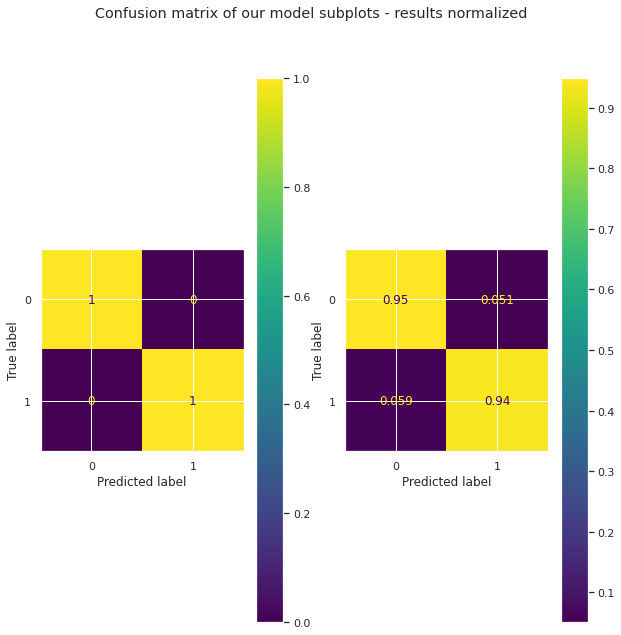

In [ ]:
#@title Running the original data set through an unoptimised Decision Tree Classifier
#@markdown There appears to be a strong overfit of the data when we use all our training set there is a large disparity between the training set accuracy and the development test accuracy
t = Timer()
t.start()
dtModel = DecisionTreeClassifier()

# The following fits and returns predictions 
y_pred_train, y_pred_test = getPredictions(non_Transformed_X_train, Y_train, non_Transformed_X_test, dtModel)
dtOriginalDuration = t.stop()
displayMetrics(Y_train, y_pred_train, Y_test, y_pred_test, dtModel.classes_)

print("Time taken:\t", dtOriginalDuration, " seconds \n\n")

We can see the results are better than the Logistic Regression, but there appears to be a strong overfit of the data when we use all our training set features. The prediction on the training data set was 'perfect' which means the model has likely created a tree that has overfit the training data. There also appears to be a large disparity between the training set accuracy and the development test accuracy (high variance). Let's explore this further with a learning curve:

***
Learning curve for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
***


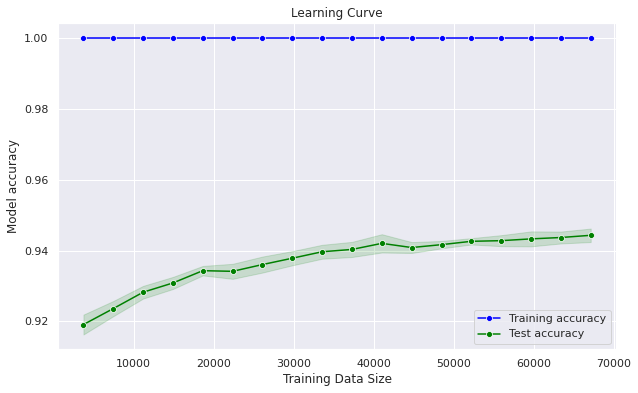

In [ ]:
plot_learning_curve(dtModel, non_Transformed_X_train, Y_train)

The learning curve confirms the below observations: the unoptimised DT on the original dataset suffers from both high bias and high variance. Adding more data (if it were available) wouldn't necessarily benefit the model, since the dev accuracy seems to plateau at the end, and we would likely continue suffering from overfitting.

Therefore, we are going to try to use the reduced feature set in order to simplify the data that is fed into the model, with the aim of reducing the overfit.

In [ ]:
# Again using our best model features as identified in 2a
bestModelFeatures = ['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'TOTALDELAY', 'AVERAGESERVICE']

# One hot encode our new features, we will be hot encoding our X_train data and X_test data
OneHotEncodedDf_X_train = pd.get_dummies(X_train[bestModelFeatures])
OneHotEncodedDf_X_test = pd.get_dummies(X_test[bestModelFeatures])

In [ ]:
OneHotEncodedDf_X_train.shape, OneHotEncodedDf_X_test.shape, X_train.shape, X_test.shape

((93234, 20), (10360, 20), (93234, 20), (10360, 20))

OneHotEncodedDf has created new columns in our data set. New feature columns created by One-hot Encoding are vector representations in which all of the elements in a vector are 0, except for one, which has 1 as its value, where 1 represents a boolean specifying a category of the element. Implementing hot encoding will help the classifier to make efficient and faster decisions as the new feature inputs are bound to only two cases.


Train Classification Results
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     52827
           1       0.98      0.96      0.97     40407

    accuracy                           0.98     93234
   macro avg       0.98      0.98      0.98     93234
weighted avg       0.98      0.98      0.98     93234

Dev Test Classification Results
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5870
           1       0.93      0.92      0.92      4490

    accuracy                           0.93     10360
   macro avg       0.93      0.93      0.93     10360
weighted avg       0.93      0.93      0.93     10360

Time taken:	 0.8  seconds 




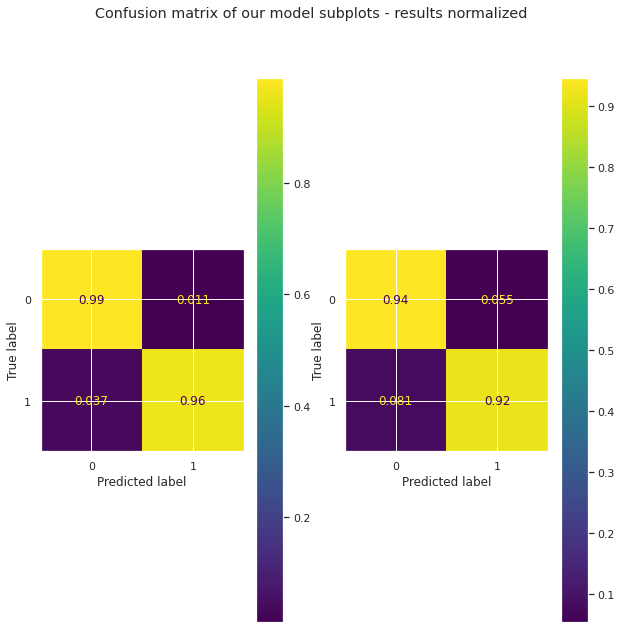

In [ ]:
dtModel = DecisionTreeClassifier()
t.start()
y_pred_train, y_pred_test = getPredictions(OneHotEncodedDf_X_train, Y_train, OneHotEncodedDf_X_test, dtModel)
dtBestFeaturesDuration = t.stop()
displayMetrics(Y_train, y_pred_train, Y_test, y_pred_test, dtModel.classes_)
print("Time taken:\t", dtOriginalDuration, " seconds \n\n")


***
Learning curve for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
***


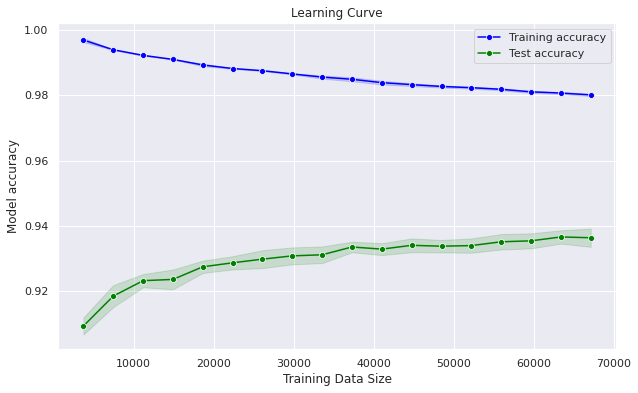

In [ ]:
plot_learning_curve(dtModel, OneHotEncodedDf_X_train, Y_train)

Although the training set and dev test accuracy has gone down compared to the original its important to note this is because we aimed to break the overfit. We still have a disparity between the development set and the training set so an overfit still likely exists in our classifier model. Better optimisations can be implemented to hopefully reduce the overfit such as reducing the depth, increasing the number of samples per leaf and also maximum leaf samples. We can also identify as the training data increases they do begin convergence. However we are unable to procure additional data at present. 

## 3c) Optimization

We should be able to do better than the model above. As mentioned before we will attempt to optimize for better accuracy and reduced variance, so we will try pruning the leaves and alter the minimum samples per leaf and also tune our max depth.

In [ ]:
originalDataNodeCount = dtModel.tree_.node_count 
originalDataLeavesCount = dtModel.tree_.n_leaves
originalDataDepth = dtModel.tree_.max_depth
print("Node Count: \t\t", originalDataNodeCount)
print("Leaves Count: \t\t", originalDataLeavesCount)
print("Max Depth: \t\t", originalDataDepth)

Node Count: 		 12351
Leaves Count: 		 6176
Max Depth: 		 29


With a small amount of data and features, visualising the graph tree using the export_graphviz method from sklearn.tree would have provided better insight into what is happening inside the model. With 20 features and a large dataset for the airline satisfaction model, the graph would be too large for cairo-renderer bitmaps, making it too complex to analyse the image. Instead, we used the properties of the model tree to learn about the number of nodes, leaves and depth of the tree. The above output shows the number of nodes, leaves and maximum depth in the tree model.
Leaves are the nodes of the tree that have no additional nodes coming off them. Max depth is the maximum depth of the tree that was created. We may be able to toggle some of these values and get more optimized model, and to assist us with this task, we use GridSearchCV.

BEST PARAMS:  {'max_leaf_nodes': 260, 'min_samples_leaf': 2}


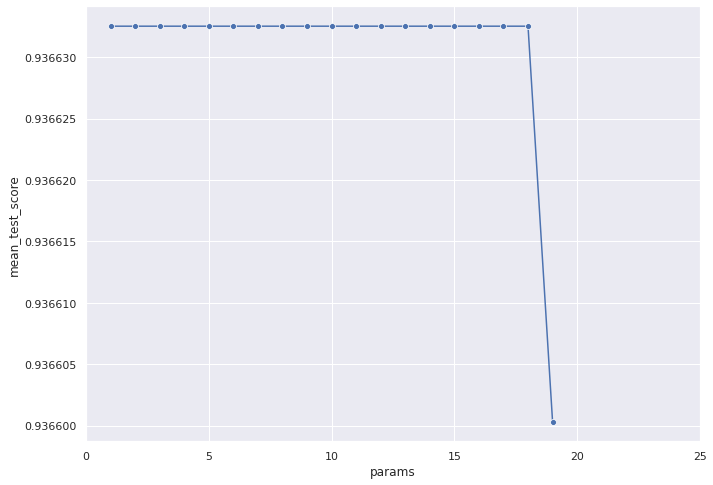

The above tuning has determined that the number of max-leaf nodes should be 260, and the minimum number of samples per leaf should be 2. Unfortunately, it doesn't give us a realistic view of the affects of the individual parameters. Ideally, we would prefer more leaf samples just to prevent an overfit. But we will test this with our max depth parameter

In [ ]:
# From the search in the codeblock above our results showed the following
max_leaf = 260
min_samples = 2

# Check to see if a depth will make it better
maxDepth = list(range(1,25))
params = {'max_depth':maxDepth}
gridDepth = GridSearchCV(DecisionTreeClassifier(max_leaf_nodes=max_leaf, min_samples_leaf=min_samples), param_grid=params, cv=5)
gridDepth.fit(OneHotEncodedDf_X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=260,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=2,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
 

In [ ]:
print("BEST Depth: ", gridDepth.best_params_)

BEST Depth:  {'max_depth': 18}


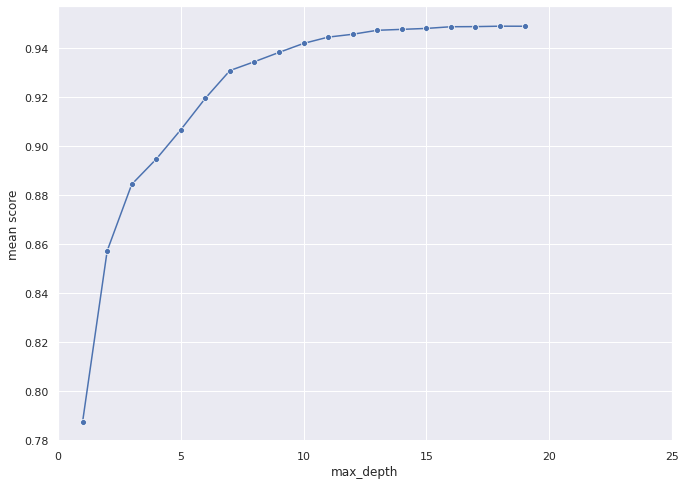

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
meanTestScore = gridDepth.cv_results_['mean_test_score']
depthScores_df = pd.DataFrame.from_records(zip(minLeafSamples,meanTestScore), columns=['max_depth','mean score'])
sns.lineplot(data=depthScores_df, x='max_depth', y='mean score', palette=colourPalette, marker='o').set(xlim=(0,25));

When we evaluate the depth versus our accuracy we can see that it is going to have a detrimental effect if we have a too shallow model. We tested this between 0 and 20 with 1 increment and it can be seen that it begins to taper off after a depth of 14 and asymptotic onward with no meaningful gain. It's worth noting that the missing datapoints from 20 above are likely because the change in our other parameters such as min samples per leaf and maximum leaf nodes will also limit the absolute depth of our model based on the size of our data set. 

In [ ]:
# Just examining whether it comes to the same conclusion when we use max_leaf and max_depth and plot it we can see the difference is negligable
max_depth = 18
max_leaf = 260
min_samples_leaf = list(range(1,25))
params = {'min_samples_leaf':min_samples_leaf}
gridminLeaf= GridSearchCV( DecisionTreeClassifier(max_leaf_nodes=max_leaf, max_depth=max_depth), param_grid=params, cv=5, return_train_score=True)
gridminLeaf.fit(OneHotEncodedDf_X_train, Y_train)
gridminLeaf.best_params_


{'min_samples_leaf': 2}

When we ran it in reverse to see if we would get the same result, this time it gave us a min_samples_leaf of 1. However, we are not going to use that, as we know this is absolutely going to have a negative effect on our test data. A sample of one means that it can identify individual samples directly, meaning a strong overfit of our training data.

In [ ]:
meanTestScore = gridminLeaf.cv_results_['mean_test_score']
meanTrainScore = gridminLeaf.cv_results_['mean_train_score']
mLScores_df = pd.DataFrame.from_records(zip(minLeafSamples,meanTestScore, meanTrainScore), columns=['min_samples_leaf','mean test score','mean train score'])
mLScores_df.head()


min_samples_leaf  mean test score  mean train score
0                 1         0.948785          0.952466
1                 2         0.948785          0.952469
2                 3         0.948291          0.952383
3                 4         0.947830          0.952179
4                 5         0.947498          0.951855

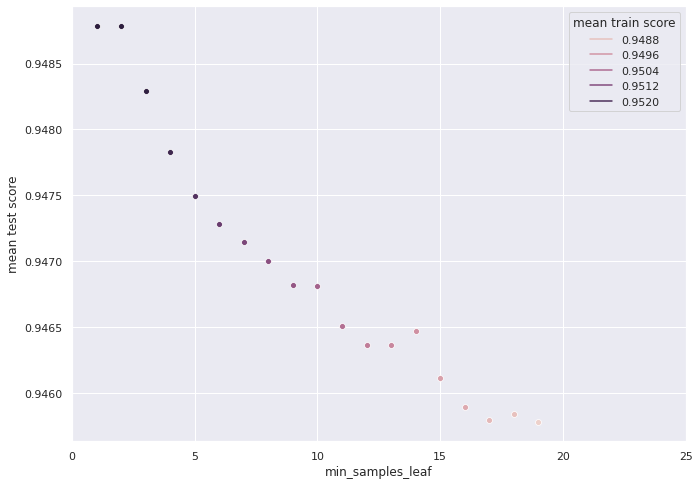

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
sns.lineplot(data=mLScores_df, x='min_samples_leaf', y='mean test score', hue='mean train score', marker='o').set(xlim=(0,25));

Our hyperparameter of min_samples_leaf has very little effect on our model overall, we did not want to use 1, but 2 at face value gives us a similar result. We can see with the given hue however there is a stronger overfit between them both as their darker colour indicates that the training score and test score diverge by a small amount. As we increase those samples per leaf they converge and approach similar accuracies. But consideration here must be given to the fact the difference between the two is quite low, a 0.4% spread between best and worse. So we will continue to use the recommended parameters from our grid search and build our entire model.

Now that we have trialled out the best features and parameters, let's re-train the model on the full training dataset, and assess its performance.

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     58697
           1       0.95      0.94      0.94     44897

    accuracy                           0.95    103594
   macro avg       0.95      0.95      0.95    103594
weighted avg       0.95      0.95      0.95    103594


TIME TAKEN TO TRAIN AND PREDICT:  0.2 




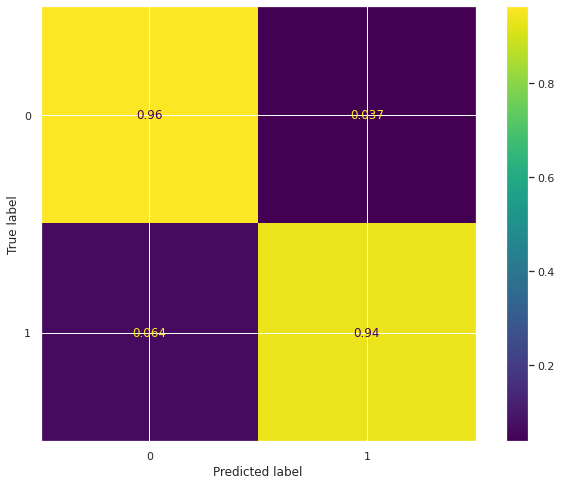

In [ ]:
# Test with new min leaf samples and all features on the full data set now that we have trialled our features

t = Timer()

max_depth = 18
max_leaf = 260
min_samples_leaf = 2
# This is the full dataset not split
OneHotEncodedFullDf = pd.get_dummies(trainDf[bestModelFeatures])

t.start()
dtModel = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf, min_samples_leaf=min_samples_leaf)
dtModel.fit(OneHotEncodedFullDf, trainDf['SATISFACTION'])
Y_pred_full = dtModel.predict(OneHotEncodedFullDf)
dtFullDuration = t.stop()

print(classification_report(trainDf['SATISFACTION'], Y_pred_full))

fullDtConfustionMatrix = confusion_matrix(trainDf['SATISFACTION'], Y_pred_full, labels=dtModel.classes_, normalize='true')

ConfusionMatrixDisplay(confusion_matrix=fullDtConfustionMatrix, display_labels=dtModel.classes_).plot()

print("\nTIME TAKEN TO TRAIN AND PREDICT: ", dtFullDuration, "\n\n")

In [ ]:
dtModel.tree_.node_count, dtModel.tree_.n_leaves

(519, 260)

After providing value for maximum depth, maximum leaf and minimum samples leaves, the classification report for both training and dev testing are close to each other. Although the accuracy on the training set has decreased the discrepancy between the training and the development test accuracy are more similar meaning we are not suffering from that higher variance. Additionally, we can see the number of nodes and leaves has come down a lot, with the new changes, so our tree is a lot smaller.

## 3d) Evaluation and Summary

Comparing Oridinal model with optimised model

In [ ]:
optimisedDataNodeCount = dtModel.tree_.node_count 
optimisedDataLeavesCount = dtModel.tree_.n_leaves
optimisedDataDepth = dtModel.tree_.max_depth
print("Node Count: \t\t", optimisedDataNodeCount)
print("Leaves Count: \t\t", optimisedDataLeavesCount)
print("Max Depth: \t\t", optimisedDataDepth)

Node Count: 		 519
Leaves Count: 		 260
Max Depth: 		 18


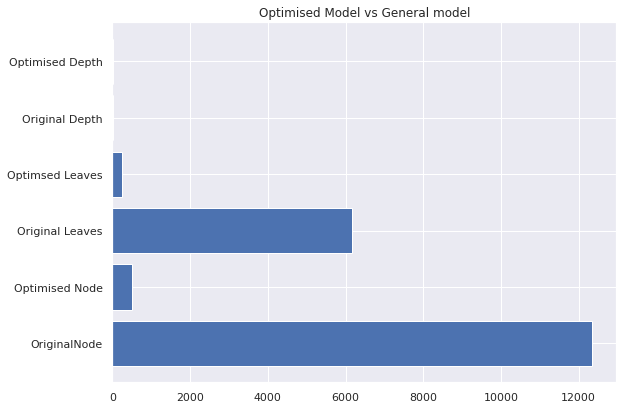

In [ ]:
comparisonFigure3 = plt.figure(figsize=(7,5))

ax = comparisonFigure3.add_axes([0,0,1,1])
modelLabels = ['OriginalNode', 'Optimised Node', 'Original Leaves', 'Optimsed Leaves', 'Original Depth', 'Optimised Depth']
scores = [originalDataNodeCount,optimisedDataNodeCount,originalDataLeavesCount,optimisedDataLeavesCount,originalDataDepth, optimisedDataDepth]

ax.barh(modelLabels,scores)
ax.set_title("Optimised Model vs General model")

plt.show()

It was noticed that the number of leaf nodes (those that have no additional nodes coming off them) has decreased by a large amount. The number of nodes also have dropped from 12331 to 519.
Restricting how deep the tree can grow and enforcing the leaf nodes to associate to at least two samples have decreased the overfitting issue we faced during the first training stage. This restricted the tree to create a bunch of small branches for one sample each. By comparing the mean test and training score against different min_samples_leaf, it was noticed that having a high value would decrease the accuracy of the model.
We also established that having a very low depth would underfit the model and decrease the accuracy by a large margin.

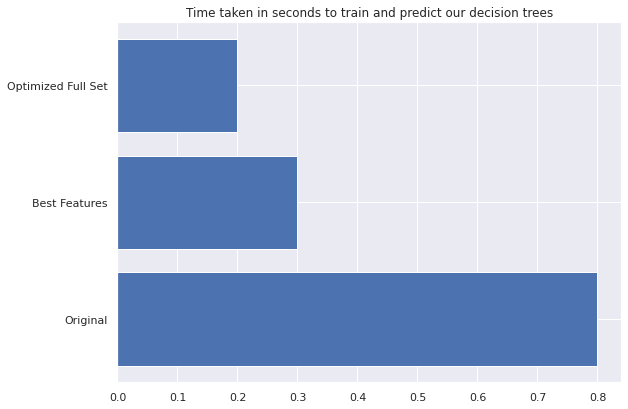

In [ ]:
comparisonFigure3 = plt.figure(figsize=(7,5))

ax = comparisonFigure3.add_axes([0,0,1,1])
modelLabels = ['Original', 'Best Features', 'Optimized Full Set']
scores = [dtOriginalDuration,dtBestFeaturesDuration, dtFullDuration]
ax.barh(modelLabels,scores)
ax.set_title("Time taken in seconds to train and predict our decision trees")

plt.show()

Unlike our Logistic Regression model, the Decision Tree Classifier is significantly more performant. It is faster at training and making predictions. The original full data set, however, takes about 250% more time than our reduced feature set. We can see if time were a critical factor (i.e. if predictions were to be made in real-time) this model coupled with its accuracy would be a very strong candidate over a logistic regression model.

#### Evaluating our best model against the Test Data

Our Decision Tree Classifier model is now ready to be assessed against the 'unseen' test data. Up to this point, it has been trained and

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     14528
           1       0.89      0.92      0.90     11365

    accuracy                           0.91     25893
   macro avg       0.91      0.91      0.91     25893
weighted avg       0.91      0.91      0.91     25893



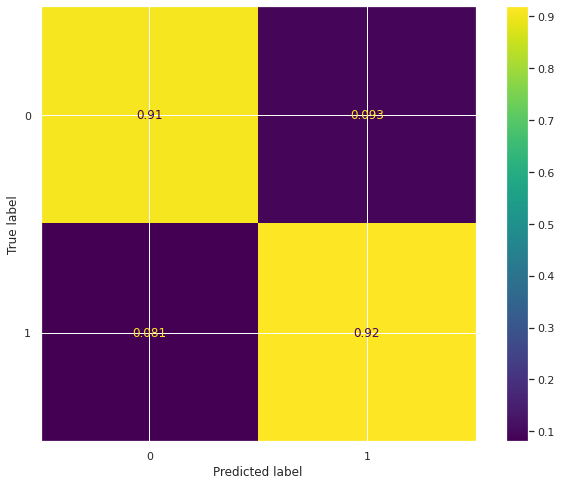

In [ ]:
testFeaturePrediction = dtModel.predict(pd.get_dummies(testDf[bestModelFeatures]))
print(classification_report(testDf['SATISFACTION'], testFeaturePrediction))

unseenDataDTModelConfusionMatrix = confusion_matrix(testDf['SATISFACTION'], testFeaturePrediction, labels=dtModel.classes_, normalize='true');

ConfusionMatrixDisplay(confusion_matrix=unseenDataDTModelConfusionMatrix, display_labels=dtModel.classes_).plot();

In [ ]:
bestDTCModelAccuracy = accuracy_score(testDf['SATISFACTION'], testFeaturePrediction).round(3)
print(f'Accuracy on test (unseen) data: {bestDTCModelAccuracy}')

Accuracy on test (unseen) data: 0.912


#### Summary

We started the Decision Tree Classifier model selection process with an unoptimised model, on a full-featured training dataset to get a general idea of the baseline performance of the model. We quickly realised that such a model suffers from overfitting, as the performance on the training data was a perfect 100%, and there appeared to be a wide gap between training and dev data performance.

The first action point was therefore to try to minimise overfit, which we approached by reducing the feature set, by leveraging previous feature engineering work. We experimented with the best features that had been determined at an earlier phase and conducted one-hot encoding, a step known to help DTC models make more efficient decisions. With these changes, there was a marginal reduction in accuracy, but so there was a slight reduction in overfit. Nevertheless, the high variance was still present, as apparent in the persisting gap between training and development test accuracy.

Therefore, we turned our attention to how to optimise the model by conducting hyper-parameter tuning. We first started by looking at the original number of nodes, leaves and depth of the tree in an unoptimised DTC. Then we ran GridSearchCV to attempt to establish the best values for the min_samples_leaf, max_leaf_nodes and max_depth parameters of the DTC. The initial suggestion by GridSearchCV for min_samples_leaf was 1, which would clearly lead to overfitting, as the model would be learning too many details, and failing to recognise the generalized pattern. So we conducted some experimentation and landed at the value 2 for this parameter (higher values didn't seem to have a positive effect). With the final best values for the hyper-parameters, we then re-trained the model, this time using the full-sample dataset (that is, not on the 90% split, but using 100% of the training data). This yielded the best results, in terms of accuracy, and minimization of bias and variance.

We also analysed the training and prediction time efficiency across the three DTC models. It was abundantly clear that there is a clear benefit of reducing the feature set since both the unoptimised and optimised models that relied on reduced dimensionality were more than X2.5 times faster than the unoptimised model using the full-feature set.

Finally, once it was clear that the optimised model using the best features was the best candidate, we assessed its performance on unseen test data. We found that although the 91% accuracy on the unseen data vs 95% on the train+develop data suggests some degree of overfitting, this is a considerable gain when compared to the best LR model, whilst also considering the gain in speed that DT provides. These factors motivated our decision to settle on this DTC model, and not iterate over feature selection or parameter tuning any further.


# 4. Feed Forward Neural Net

## 4a) Data Preparation

The same training and test data created during the data preparation phase will be used to train the feed-forward neurual network. Training and assessing the model's performance on the same data will help us to make a better unbiased and accurate decision when recommending the model. Please view the [data preparation phase](`https://colab.research.google.com/drive/1jc7jpVnR6NNe7JQRPCk-fVcOQiTx52f1?authuser=1#scrollTo=1c_Data_Preparation`) section for detailed data split process.



Next, we apply normalization around 0 with a standard deviation of 1. Neuronal networks can benefit from data that exhibits a standard scale, and that has been normalised, such as when the input values are all small numbers in the range 0,...,1. We use the Normalization function for this.


In [ ]:
# apply normalization around 0 with a standard deviation of 1
normalizer = Normalization(axis=-1)
normalizer.adapt(X_train)

## 4b) Establishing a Network Architecture & Training

In [ ]:
#@title Test and Verify if GPU is available
!nvidia-smi

Sat Nov  6 20:39:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    72W / 149W |    155MiB / 11441MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Our process to determine an optimal Neural Network Architecture starts by establishing a baseline NN that we can use to gain initial insights. The following method has been updated to reflect our best chosen as the default model. 

In [ ]:
#@title FF Helper Methods
#@markdown this is included down here and not up with the helpers as it better demonstrates our final architecture

# Note the default model within was established based on trials below, and has just been added here to ensure it runs before everything else. 

# Takes a model and compiles, if no model is supplied it will create one using our established architecture below
# Takes a number of features 
def getFFModel(featureCount = 5, model=False, optimizer='adam'):

    #Default custom 
  if not model:
      model = Sequential([normalizer,
                          tf.keras.layers.Dense(featureCount, activation='relu'),
                          tf.keras.layers.Dense(featureCount*2, activation='relu'),
                          tf.keras.layers.Dense(featureCount, activation='relu'),
                          tf.keras.layers.Dense(1, activation='sigmoid')])
        
  model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
  return model


First we will roughly evaluate how changing the **number of nodes** in our hidden layer will impact our model.

In [ ]:
nodes = [4,5,6,7,8,10,12,14,20]

In [ ]:
#WARNING this takes a while to complete, depending on batch size, so I have copied the data into the variable modelscore in the next code block
#Evalutes how the nodes affect our model
modelScore = []  
for nodeNumber in nodes:
    basicModel = Sequential([normalizer, Dense(nodeNumber, activation='relu'), Dense(1, activation='sigmoid')])
    basicFFModel = getFFModel(nodeNumber, model=basicModel)
    basicFFModel.fit(X_train, Y_train, epochs=3, validation_split=0.1)
    modelScore.append(basicFFModel.evaluate(X_test, Y_test, return_dict=True))

Epoch 1/3
2623/2623 [==============================] - 12s 4ms/step - loss: 0.3044 - accuracy: 0.8808 - val_loss: 0.2371 - val_accuracy: 0.9092
Epoch 2/3
2623/2623 [==============================] - 9s 4ms/step - loss: 0.2102 - accuracy: 0.9181 - val_loss: 0.2103 - val_accuracy: 0.9176
Epoch 3/3
324/324 [==============================] - 1s 2ms/step - loss: 0.1975 - accuracy: 0.9188
Epoch 1/3
2623/2623 [==============================] - 10s 4ms/step - loss: 0.3405 - accuracy: 0.8622 - val_loss: 0.2632 - val_accuracy: 0.8968
Epoch 2/3
2623/2623 [==============================] - 9s 3ms/step - loss: 0.2236 - accuracy: 0.9132 - val_loss: 0.2157 - val_accuracy: 0.9150
Epoch 3/3
324/324 [==============================] - 1s 2ms/step - loss: 0.1973 - accuracy: 0.9185
Epoch 1/3
2623/2623 [==============================] - 10s 4ms/step - loss: 0.2789 - accuracy: 0.8893 - val_loss: 0.2247 - val_accuracy: 0.9126
Epoch 2/3
2623/2623 [==============================] - 9s 3ms/step - loss: 0.2041 - 

In [ ]:
modelScore

[{'accuracy': 0.9188224077224731, 'loss': 0.19753262400627136},
 {'accuracy': 0.9185327887535095, 'loss': 0.19730111956596375},
 {'accuracy': 0.926447868347168, 'loss': 0.18734313547611237},
 {'accuracy': 0.9259652495384216, 'loss': 0.18264402449131012},
 {'accuracy': 0.9274131059646606, 'loss': 0.1817135065793991},
 {'accuracy': 0.9285714030265808, 'loss': 0.17758074402809143},
 {'accuracy': 0.9304053783416748, 'loss': 0.16888365149497986},
 {'accuracy': 0.9310810565948486, 'loss': 0.16741134226322174},
 {'accuracy': 0.9332046508789062, 'loss': 0.16772273182868958}]

NODECOUNT  ACCURACY      LOSS
0          4  0.918822  0.197533
1          5  0.918533  0.197301
2          6  0.926448  0.187343
3          7  0.925965  0.182644
4          8  0.927413  0.181714
5         10  0.928571  0.177581
6         12  0.930405  0.168884
7         14  0.931081  0.167411
8         20  0.933205  0.167723

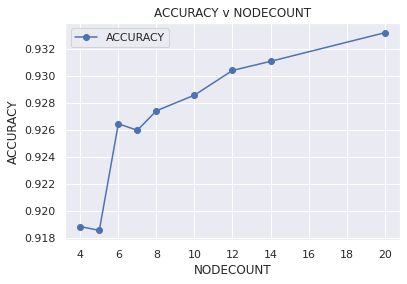

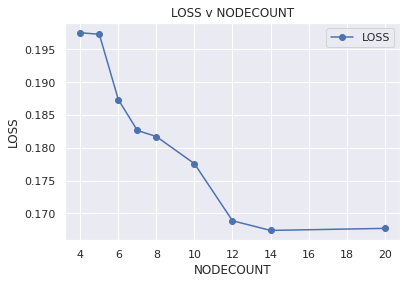

In [ ]:
modelScore = [{'accuracy': 0.9188224077224731, 'loss': 0.19753262400627136},
 {'accuracy': 0.9185327887535095, 'loss': 0.19730111956596375},
 {'accuracy': 0.926447868347168, 'loss': 0.18734313547611237},
 {'accuracy': 0.9259652495384216, 'loss': 0.18264402449131012},
 {'accuracy': 0.9274131059646606, 'loss': 0.1817135065793991},
 {'accuracy': 0.9285714030265808, 'loss': 0.17758074402809143},
 {'accuracy': 0.9304053783416748, 'loss': 0.16888365149497986},
 {'accuracy': 0.9310810565948486, 'loss': 0.16741134226322174},
 {'accuracy': 0.9332046508789062, 'loss': 0.16772273182868958}]

nodes = [4,5,6,7,8,10,12,14,20]

plotModelAccuracyAndLoss(modelScore, nodes, "NODECOUNT")

From the above chart, we see that on a single layer FFNN, as we increase the number of nodes in the hidden layer, the accuracy increases slightly and the loss decreases to a point. It seems that for increased accuracy (but potentially an overfit), we should try using a larger number of nodes. Thankfully the loss appears to remain asymptotic after 14 neurons, with no reversal, which may indicate an issue with our training or a hard limit. 

Now that we have a better understanding of how the nodes may affect our model, we will attempt **adding a few layers**, starting with the number of input features as our first dense hidden layer, and reducing it as we attempt more layers.  We will also try an additional layer with the node counts of FeatureCount, FeatureCount*2, FeatureCount:

In [ ]:
bestNodeCount = len(X_train.columns)
modelLayers = [
          Sequential([normalizer, Dense(bestNodeCount, activation='relu'), Dense(1, activation='sigmoid')]),\
          Sequential([normalizer, Dense(bestNodeCount, activation='relu'), Dense(round(bestNodeCount/2), activation='relu'), Dense(1, activation='sigmoid')]),\
          Sequential([normalizer, Dense(bestNodeCount, activation='relu'), Dense(round(bestNodeCount/2), activation='relu'), Dense(round(bestNodeCount/4), activation='relu'), Dense(1, activation='sigmoid')]),\
          Sequential([normalizer, Dense(bestNodeCount, activation='relu'), Dense(bestNodeCount*2, activation='relu'), Dense(bestNodeCount, activation='relu'), Dense(1, activation='sigmoid')])]

In [ ]:
# This is part of our number of hidden layer evaluations
modelLayerScores = []
for model in modelLayers:
    ffModel = getFFModel(_, model)
    ffModel.fit(X_train, Y_train, epochs=3, validation_split=0.1)
    modelLayerScores.append(ffModel.evaluate(X_test, Y_test, return_dict=True))

Epoch 1/3
2623/2623 [==============================] - 7s 3ms/step - loss: 0.2627 - accuracy: 0.8933 - val_loss: 0.1987 - val_accuracy: 0.9200
Epoch 2/3
2623/2623 [==============================] - 7s 2ms/step - loss: 0.1782 - accuracy: 0.9290 - val_loss: 0.1797 - val_accuracy: 0.9263
Epoch 3/3
324/324 [==============================] - 1s 2ms/step - loss: 0.1648 - accuracy: 0.9319
Epoch 1/3
2623/2623 [==============================] - 7s 3ms/step - loss: 0.2332 - accuracy: 0.9083 - val_loss: 0.1833 - val_accuracy: 0.9247
Epoch 2/3
2623/2623 [==============================] - 7s 3ms/step - loss: 0.1680 - accuracy: 0.9336 - val_loss: 0.1706 - val_accuracy: 0.9309
Epoch 3/3
324/324 [==============================] - 1s 2ms/step - loss: 0.1603 - accuracy: 0.9327
Epoch 1/3
2623/2623 [==============================] - 8s 3ms/step - loss: 0.2342 - accuracy: 0.9076 - val_loss: 0.1772 - val_accuracy: 0.9289
Epoch 2/3
2623/2623 [==============================] - 7s 3ms/step - loss: 0.1567 - acc

In [ ]:
modelLayerScores

[{'accuracy': 0.9318532943725586, 'loss': 0.16484501957893372},
 {'accuracy': 0.9327220320701599, 'loss': 0.16033658385276794},
 {'accuracy': 0.9395753145217896, 'loss': 0.13870728015899658},
 {'accuracy': 0.9438223838806152, 'loss': 0.1275394856929779}]

LAYERS  ACCURACY      LOSS
0       1 Layer  0.931853  0.164845
1       2 Layer  0.932722  0.160337
2       3 Layer  0.939575  0.138707
3  Custom Layer  0.943822  0.127539

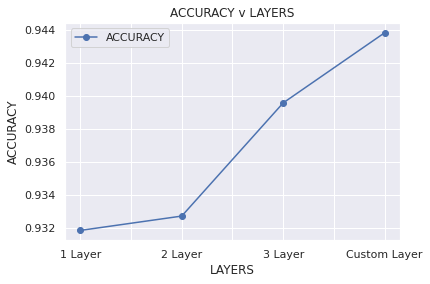

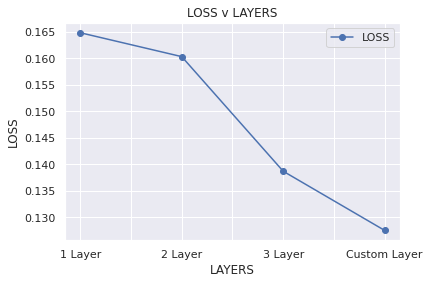

In [ ]:
modelLayerScores = [{'accuracy': 0.9318532943725586, 'loss': 0.16484501957893372},
 {'accuracy': 0.9327220320701599, 'loss': 0.16033658385276794},
 {'accuracy': 0.9395753145217896, 'loss': 0.13870728015899658},
 {'accuracy': 0.9438223838806152, 'loss': 0.1275394856929779}]

modelLayerLabel = ['1 Layer', '2 Layer', '3 Layer', 'Custom Layer']

plotModelAccuracyAndLoss(modelLayerScores, modelLayerLabel, "LAYERS")

As it can be seen, the overall the accuracy and loss are fairly satisfactory (>93%). The more epochs we do, the greater the accuracy and validation accuracy, and the validation loss decreases. Moreover, the above diagram demonstrates that as we increase the number of hidden layers, we get a slight increase in accuracy. However, this only appears to be a small percentage gain overall, whilst there seems to be a slight duration penalty, but not too significant. On the other hand, it is worth mentioning, as identified in the Loss chart, the loss decreases significantly from 16.5% down to less than 13%, so there is an apparent improvement due to model depth.  

From the above, we have identified a model that best fits our criteria for moving forward, and have **decided upon using our Custom Layer Architecture**. Therefore, we have made this our default model in our *getFFModel method*.

The chosen architecture consists of:

- A normalization layer
- A dense layer that contains nodes equivalent to our node count
- A dense layer that contained nodes equivalent to 2 x our node count
- Another dense layer as before with our node count
- A single output layer

All of the Dense hidden layers make use of the relu activation function with a sigmoid activation function for the output. The below two figures visualise this architecture.

In [ ]:
BATCH_SIZE = 16   #This has been added here after testing just to establish a constant
FEATURE_COUNT = len(X_train.columns)
ffModel = getFFModel(FEATURE_COUNT)
ffModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 20)                41        
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,142
Trainable params: 2,101
Non-trainable params: 41
_________________________________________________________________


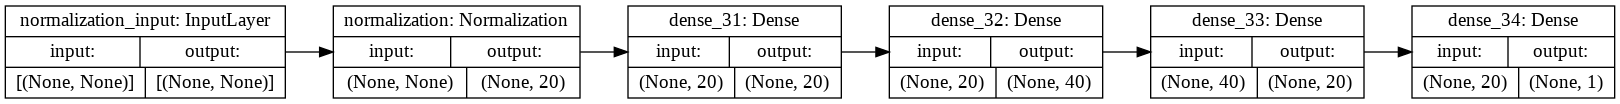

In [ ]:
plot_model(ffModel, rankdir="LR", show_shapes=True)

We will now try to optimize our discovered architecture. This model uses binary cross-entropy as the loss function and uses accuracy as the chosen metric. We will attempt to optimize the number of **batches** and **epochs** as the **time and resources** taken to train will vary significantly, so it's important to establish a satisfactory compromise between the three.

## 4c) Optimization

### Batch Optimization


To attempt to find an optimal batch size, we capture scores across a range of batch sizes: 2, 4, 8, 16, 24, 32, 48, 64, 128.

In [ ]:
# Warning: this takes greater than 20 mins on GPU, results have been copied to a variable in the next code block
# This tests everything in batch array  as parameters for batch size and stores the accuracy on test data in the scores array
batchArray = [2, 4, 8, 16, 24, 32, 48, 64, 128]
ffModel = getFFModel(FEATURE_COUNT)
batchScores = []
for batch in batchArray:
    ffModel = getFFModel(FEATURE_COUNT)
    ffModel.fit(X_train, Y_train, epochs=3, validation_split=0.1, batch_size=batch)
    batchScores.append(ffModel.evaluate(X_test, Y_test, return_dict=True))

Epoch 1/3
41955/41955 [==============================] - 120s 3ms/step - loss: 0.1659 - accuracy: 0.9319 - val_loss: 0.1452 - val_accuracy: 0.9390
Epoch 2/3
41955/41955 [==============================] - 118s 3ms/step - loss: 0.1293 - accuracy: 0.9465 - val_loss: 0.1311 - val_accuracy: 0.9465
Epoch 3/3
324/324 [==============================] - 1s 3ms/step - loss: 0.1257 - accuracy: 0.9486
Epoch 1/3
20978/20978 [==============================] - 80s 4ms/step - loss: 0.1690 - accuracy: 0.9306 - val_loss: 0.1375 - val_accuracy: 0.9427
Epoch 2/3
20978/20978 [==============================] - 79s 4ms/step - loss: 0.1250 - accuracy: 0.9480 - val_loss: 0.1303 - val_accuracy: 0.9451
Epoch 3/3
324/324 [==============================] - 1s 3ms/step - loss: 0.1172 - accuracy: 0.9499
Epoch 1/3
10489/10489 [==============================] - 41s 4ms/step - loss: 0.1845 - accuracy: 0.9249 - val_loss: 0.1553 - val_accuracy: 0.9310
Epoch 2/3
10489/10489 [==============================] - 40s 4ms/step 

In [ ]:
batchScores

[{'accuracy': 0.948552131652832, 'loss': 0.12565384805202484},
 {'accuracy': 0.9499034881591797, 'loss': 0.11718164384365082},
 {'accuracy': 0.948938250541687, 'loss': 0.11847542226314545},
 {'accuracy': 0.948938250541687, 'loss': 0.11942284554243088},
 {'accuracy': 0.9470077157020569, 'loss': 0.12676335871219635},
 {'accuracy': 0.9453667998313904, 'loss': 0.12485142797231674},
 {'accuracy': 0.9421814680099487, 'loss': 0.1365320384502411},
 {'accuracy': 0.9368726015090942, 'loss': 0.14539197087287903},
 {'accuracy': 0.9378378391265869, 'loss': 0.1502532809972763}]

BATCH SIZE  ACCURACY      LOSS
0           2  0.948552  0.125654
1           4  0.949903  0.117182
2           8  0.948938  0.118475
3          16  0.948938  0.119423
4          24  0.947008  0.126763
5          32  0.945367  0.124851
6          48  0.942181  0.136532
7          64  0.936873  0.145392
8         128  0.937838  0.150253

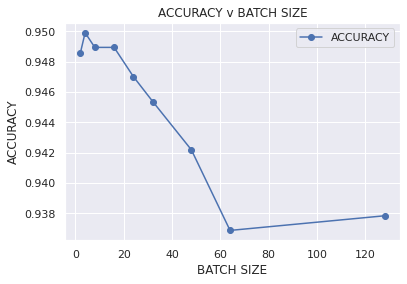

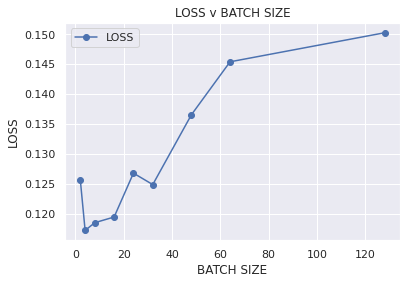

In [ ]:
batchArray = [2, 4, 8, 16, 24, 32, 48, 64, 128]
batchTimes = [120, 79, 40, 20, 14, 10, 8 ,5,3]
batchScores = [{'accuracy': 0.948552131652832, 'loss': 0.12565384805202484},
 {'accuracy': 0.9499034881591797, 'loss': 0.11718164384365082},
 {'accuracy': 0.948938250541687, 'loss': 0.11847542226314545},
 {'accuracy': 0.948938250541687, 'loss': 0.11942284554243088},
 {'accuracy': 0.9470077157020569, 'loss': 0.12676335871219635},
 {'accuracy': 0.9453667998313904, 'loss': 0.12485142797231674},
 {'accuracy': 0.9421814680099487, 'loss': 0.1365320384502411},
 {'accuracy': 0.9368726015090942, 'loss': 0.14539197087287903},
 {'accuracy': 0.9378378391265869, 'loss': 0.1502532809972763}]

plotModelAccuracyAndLoss(batchScores, batchArray, "BATCH SIZE")

From our batch optimisation results, we learned that we need to be mindful of the fact that as we increase the batch size, we potentially risk an overfit of our model, such that it lacks the correct ability to generalize our solution because it trains with less noise. However, a benefit of larger batch sizes is that it allows the model to train significantly faster due to improved parallelism. For instance, looking at the time to train a single epoch at a batch size of 2, we see that it takes 120 seconds; whereas a batch size of 128 takes a mere 3 seconds (in other words, this is 40X increase in duration for 1% accuracy in this instance).

Conversely, a low batch size may converge on a **good** result faster, but there also exists the danger of it getting stuck in a 'good' but not an optimal solution. So our decision must find the sweet spot in accordance with our charts. 

As illustrated above, a batch size of 2 definitely does not seem to be ideal, it takes the longest to train, but has a relatively low loss. Interestingly from the point of 64 onward, we begin to gain accuracy again so the model is potentially becoming too specific. After 16 is when our accuracy begins to taper off initially. 

Looking at the loss function after 16 we begin to see a strong increase in loss, which means our estimated values are further away from our true values. 

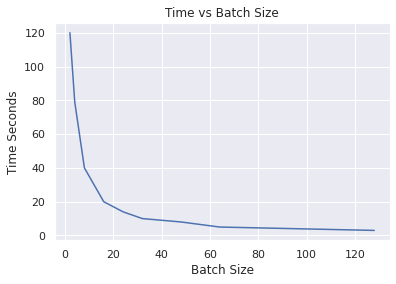

In [ ]:
sns.lineplot(x=batchArray, y=batchTimes).set(xLabel="Batch Size", yLabel="Time Seconds", title="Time vs Batch Size");

By default, the fit uses a batch size of 32, but from the results shown on the three charts above we feel **using a batch of 16** should be a good balance of time versus accuracy versus loss.

### Learning Rate Optimization

In [ ]:
#@title This takes a long time to run, to save time just run the results code block below { display-mode: "form" }

learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
historyArray = []
for rate in learning_rates:
    # fit model and plot learning curves for a learning rate
    ffModel = getFFModel(FEATURE_COUNT, False, tf.keras.optimizers.Adam(learning_rate=rate) )
    history = ffModel.fit(X_train, Y_train, epochs=15, validation_data=(X_test, Y_test), batch_size=BATCH_SIZE)
    historyArray.append(history)



In [ ]:
#@title This is the history of the above function saved for brevity { display-mode: "form" }
#@markdown Please run this before populating the next field, no need to run the above code block again.
historyObjectArray = [{'accuracy': [0.5283480286598206,
   0.532262921333313,
   0.531136691570282,
   0.5288307070732117,
   0.5314477682113647,
   0.5296887159347534,
   0.5276079773902893,
   0.5301392078399658,
   0.5295814871788025,
   0.5315120816230774,
   0.5293669700622559,
   0.5320484042167664,
   0.5312332510948181,
   0.5286590456962585,
   0.5315335392951965],
  'val_accuracy': [0.5666022896766663,
   0.5666022896766663,
   0.43339768052101135,
   0.5666022896766663,
   0.5666022896766663,
   0.43339768052101135,
   0.5666022896766663,
   0.5666022896766663,
   0.43339768052101135,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.43339768052101135]},
 {'accuracy': [0.8687817454338074,
   0.6076431274414062,
   0.7379496693611145,
   0.6710856556892395,
   0.5625308156013489,
   0.5627882480621338,
   0.5601711869239807,
   0.5624021291732788,
   0.5598708391189575,
   0.5618229508399963,
   0.5617800354957581,
   0.5590771436691284,
   0.5608147382736206,
   0.5613295435905457,
   0.5612437725067139],
  'val_accuracy': [0.7891891598701477,
   0.5666022896766663,
   0.8227798938751221,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663,
   0.5666022896766663]},
 {'accuracy': [0.9334362745285034,
   0.9451165795326233,
   0.9489135146141052,
   0.9498358964920044,
   0.9502434730529785,
   0.9508762955665588,
   0.9525709748268127,
   0.9531716108322144,
   0.9530965089797974,
   0.953386127948761,
   0.9540188908576965,
   0.9537293314933777,
   0.9544908404350281,
   0.9545552134513855,
   0.9547590017318726],
  'val_accuracy': [0.9403474926948547,
   0.9451737403869629,
   0.9462355375289917,
   0.9292470812797546,
   0.946718156337738,
   0.9472007751464844,
   0.9527027010917664,
   0.9515444040298462,
   0.952606201171875,
   0.9538609981536865,
   0.9509652256965637,
   0.9525096416473389,
   0.9531853199005127,
   0.954440176486969,
   0.9537644982337952]},
 {'accuracy': [0.9190638661384583,
   0.9420275688171387,
   0.9470257759094238,
   0.9494712352752686,
   0.9513911008834839,
   0.9519703388214111,
   0.9532573819160461,
   0.9537829756736755,
   0.9540939927101135,
   0.9549520611763,
   0.9555956125259399,
   0.9554990530014038,
   0.9563678503036499,
   0.9562605619430542,
   0.9567861557006836],
  'val_accuracy': [0.9361003637313843,
   0.9437258839607239,
   0.9482625722885132,
   0.9419884085655212,
   0.9498069286346436,
   0.9511582851409912,
   0.9475868940353394,
   0.9533783793449402,
   0.9482625722885132,
   0.9519305229187012,
   0.9493243098258972,
   0.9513513445854187,
   0.9534748792648315,
   0.9533783793449402,
   0.9527992010116577]},
 {'accuracy': [0.8689641356468201,
   0.9129073023796082,
   0.9245768785476685,
   0.9300577044487,
   0.934777021408081,
   0.9378982186317444,
   0.9398288130760193,
   0.942349374294281,
   0.9432181119918823,
   0.9446982741355896,
   0.9455456137657166,
   0.9458995461463928,
   0.9471651911735535,
   0.9475942254066467,
   0.9481304883956909],
  'val_accuracy': [0.9031853079795837,
   0.9145752787590027,
   0.926061749458313,
   0.9284749031066895,
   0.933783769607544,
   0.9372586607933044,
   0.9373552203178406,
   0.9405405521392822,
   0.9424710273742676,
   0.9424710273742676,
   0.9434362649917603,
   0.9450772404670715,
   0.9453667998313904,
   0.9470077157020569,
   0.9463320374488831]},
 {'accuracy': [0.7373383045196533,
   0.8208057284355164,
   0.844273567199707,
   0.8583885431289673,
   0.8692429661750793,
   0.8769011497497559,
   0.8838621377944946,
   0.8893536925315857,
   0.8939979076385498,
   0.8977518677711487,
   0.900594174861908,
   0.9032756090164185,
   0.9057854413986206,
   0.9077589511871338,
   0.9093464016914368],
  'val_accuracy': [0.7994208335876465,
   0.8340733647346497,
   0.8500965237617493,
   0.8594594597816467,
   0.869111955165863,
   0.8765444159507751,
   0.882335901260376,
   0.8884170055389404,
   0.8931466937065125,
   0.8972973227500916,
   0.8998069763183594,
   0.9020270109176636,
   0.9024131298065186,
   0.9042471051216125,
   0.9069498181343079]},
 {'accuracy': [0.4414162337779999,
   0.4934573173522949,
   0.6058626770973206,
   0.6859622001647949,
   0.7249394059181213,
   0.745457649230957,
   0.7578136920928955,
   0.767220139503479,
   0.7752858400344849,
   0.7818821668624878,
   0.7878777980804443,
   0.7936697006225586,
   0.7987751364707947,
   0.8031404614448547,
   0.8081386685371399],
  'val_accuracy': [0.4552123546600342,
   0.5403475165367126,
   0.6523166298866272,
   0.7046331763267517,
   0.7289575338363647,
   0.745945930480957,
   0.7567567825317383,
   0.7663127183914185,
   0.7731660008430481,
   0.7790540456771851,
   0.7856177687644958,
   0.790444016456604,
   0.7966216206550598,
   0.801833987236023,
   0.8063706755638123]},
 {'accuracy': [0.3701332211494446,
   0.37592509388923645,
   0.38170623779296875,
   0.3877984285354614,
   0.3941909670829773,
   0.4006585478782654,
   0.40753373503685,
   0.41464486718177795,
   0.42147713899612427,
   0.42922109365463257,
   0.4370937645435333,
   0.4453740119934082,
   0.4544479548931122,
   0.46273890137672424,
   0.4723491370677948],
  'val_accuracy': [0.37239381670951843,
   0.3772200644016266,
   0.3819498121738434,
   0.38764479756355286,
   0.3941119611263275,
   0.399806946516037,
   0.4072393774986267,
   0.4145752787590027,
   0.42277991771698,
   0.43281853199005127,
   0.4394787549972534,
   0.4507721960544586,
   0.45723938941955566,
   0.46621620655059814,
   0.47528958320617676]}]

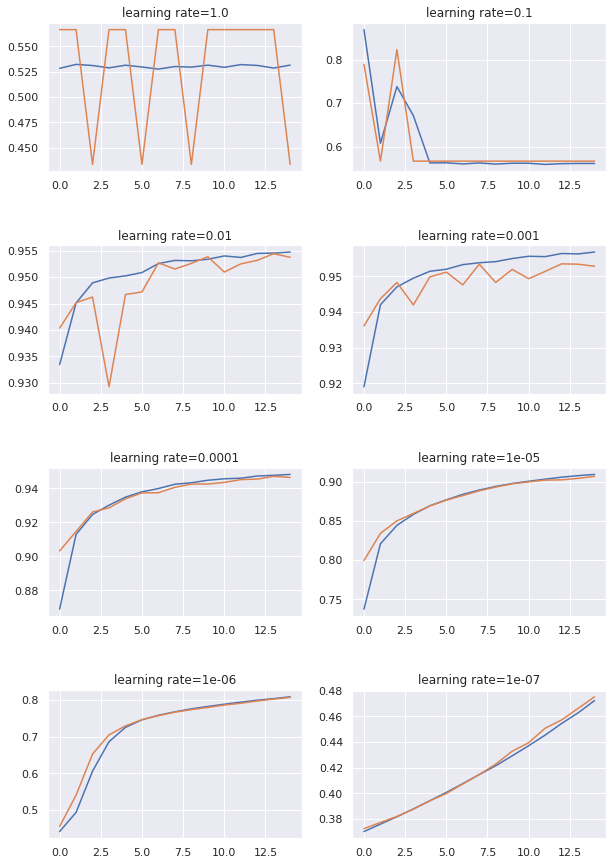

In [ ]:
# Here we are going to plot the following learning rates that decrease by a decimal place each iteration
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
plots = plt.figure(figsize=(10,15))
plots.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
for index, history in enumerate(historyObjectArray):
    
    plot = 420 + (1 + index)
    plt.subplot(plot)
    plt.plot(history['accuracy'], label='train')
    plt.plot(history['val_accuracy'], label='test')
    plt.title('learning rate='+ str(learning_rates[index]))
    plt.ylabel = 'Accuracy'
    plt.xlabel = 'Epoch'
plt.show()

As we examine the above we can easily see that within 15 epochs we do not come to a reasonable accuracy when there is a higher value for our learning rate. 

We identify that as the learning rate becomes significantly smaller it grows at a significantly slower rate for the smaller epoch size. This may be overcome with additional epochs but is going to increase the duration significantly. 

The best identified result here was the learning rate of 0.001 which happens to be the default Adam optimizer value, so we leave it at the default and check one more time to optimize the epoch vs time and accuracy below



### Epoch Optimization

Now, we turn our attention to performing epoch optimisation. We would like to further evaluate the epochs

In [ ]:
EPOCHS_TO_TRIAL = 15
history = ffModel.fit(X_train, Y_train, epochs=EPOCHS_TO_TRIAL, validation_data=(X_test, Y_test), batch_size=BATCH_SIZE)

Epoch 1/15
5828/5828 [==============================] - 25s 4ms/step - loss: 0.1886 - accuracy: 0.9244 - val_loss: 0.1461 - val_accuracy: 0.9398
Epoch 2/15
5828/5828 [==============================] - 22s 4ms/step - loss: 0.1323 - accuracy: 0.9442 - val_loss: 0.1253 - val_accuracy: 0.9462
Epoch 3/15
5828/5828 [==============================] - 22s 4ms/step - loss: 0.1203 - accuracy: 0.9487 - val_loss: 0.1200 - val_accuracy: 0.9467
Epoch 4/15
5828/5828 [==============================] - 22s 4ms/step - loss: 0.1147 - accuracy: 0.9511 - val_loss: 0.1149 - val_accuracy: 0.9507
Epoch 5/15
5828/5828 [==============================] - 22s 4ms/step - loss: 0.1110 - accuracy: 0.9527 - val_loss: 0.1138 - val_accuracy: 0.9499
Epoch 6/15
5828/5828 [==============================] - 22s 4ms/step - loss: 0.1083 - accuracy: 0.9530 - val_loss: 0.1105 - val_accuracy: 0.9518
Epoch 7/15
5828/5828 [==============================] - 22s 4ms/step - loss: 0.1069 - accuracy: 0.9541 - val_loss: 0.1112 - val_ac

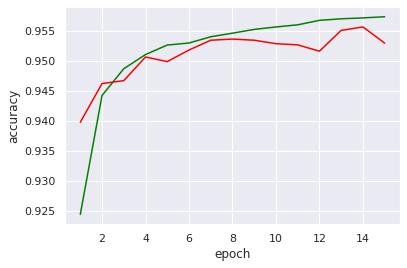

In [ ]:
# Display a visualization of epoch to accuracy
training_df = pd.DataFrame.from_dict(history.history).assign(epoch=np.array(history.epoch)+1)
sns.lineplot(data=training_df, x='epoch', y='accuracy', color='green')
sns.lineplot(data=training_df, x='epoch', y='val_accuracy', color='red');

Examining the above, we can see that the accuracy begins to taper off after the second epoch and begins to develop asymptotic behavior off as we increase further. The variance is still fluctuating around as the model accuracy vs the validation accuracy seem to diverge increasing their variance. The results aren't clear the exact trajectory. We could hypothesize this fluctuation is because the relatively low batch introduces more noise so the model is tugged around a bit. 


Due to the aspymtotic behaviour as the epochs progress, the accuracy climbs more slowly as we add more epochs. However, there is a significant increase in time taken to train the model to reach that point for little gain (On the validation set).



Then when we examine the loss function vs the epochs we immediately see a sharp decline in the loss for the first few, but the loss begins to taper off as the epochs progress:

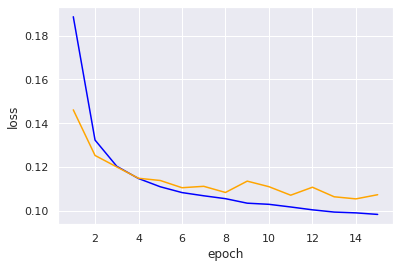

In [ ]:
#Display a visualization of epoch to loss
training_df = pd.DataFrame.from_dict(history.history).assign(epoch=np.array(history.epoch)+1)
sns.lineplot(data=training_df, x='epoch', y='loss', color='blue')
sns.lineplot(data=training_df, x='epoch', y='val_loss', color='orange');

Our best balance of epochs overtime occurs around 6-9. This is likely due to the lower batch size. We are therefore more likely to converge on an accurate result faster with fewer epochs but not gain a meaningful decrease in loss there after.


So, we have now discovered the best values for the optimisation features, namely: 

- Batch size: 16
- No. of Epochs: 6

We now proceed to re-train the **full training dataset** (i.e. 90% training data + 10% development data) with the chosen architecture and optimised features, in preparation for final evaluation against the unseen test data.

In [ ]:
# This is our full data set, we just remove the unused transformed points which we did within X_train, and also drop satisfaction
# We then convert it to a tensor, and normalize it which is one of our input layers
originalFullDf = trainDf.drop(['SERVICE', 'INFLIGHT SERVICE','ON-BOARD SERVICE', 'LEG ROOM SERVICE', 'BAGGAGE HANDLING', 'DEPARTURE DELAY IN MINUTES', 'ARRIVAL DELAY IN MINUTES' ], axis=1)
normalizer = Normalization(axis=-1)
normalizer.adapt(originalFullDf.drop('SATISFACTION', axis=1))

In [ ]:
# Our best epoch from data see chart above is 4 as the more we run 15+ the more we run the more it may overfit with high variance
# We use the full feature set for training this as its our final model after optimization
EPOCHS = 6
t = Timer()
t.start()
optimizedModel = getFFModel(len(originalFullDf.columns)-1)
history = optimizedModel.fit(originalFullDf.drop('SATISFACTION', axis=1), originalFullDf['SATISFACTION'], epochs=EPOCHS, batch_size=BATCH_SIZE)

# Do this to remain constant with our other models
Y_pred_ff = optimizedModel.predict(X_test)
feedForwardNeuralNetDuration = t.stop()

print("Time Taken: ", feedForwardNeuralNetDuration, " Seconds to Train and predict")

Epoch 1/6
6475/6475 [==============================] - 25s 4ms/step - loss: 0.1861 - accuracy: 0.9229
Epoch 2/6
6475/6475 [==============================] - 24s 4ms/step - loss: 0.1344 - accuracy: 0.9437
Epoch 3/6
6475/6475 [==============================] - 25s 4ms/step - loss: 0.1235 - accuracy: 0.9474
Epoch 4/6
6475/6475 [==============================] - 24s 4ms/step - loss: 0.1170 - accuracy: 0.9498
Epoch 5/6
6475/6475 [==============================] - 25s 4ms/step - loss: 0.1123 - accuracy: 0.9521
Epoch 6/6
6475/6475 [==============================] - 24s 4ms/step - loss: 0.1090 - accuracy: 0.9533
Time Taken:  148.2  Seconds to Train and predict


In [ ]:
print("EVALUATION of our optimized model \n")
optimizedModel.evaluate(X_test, Y_test)
# A classification report
print("\nClassification Report of our optimized model \n")
y_pred = Y_pred_ff.round(0)
print(classification_report(Y_test, y_pred, target_names=['0','1']))

EVALUATION of our optimized model 

324/324 [==============================] - 1s 3ms/step - loss: 0.1061 - accuracy: 0.9532

Classification Report of our optimized model 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5870
           1       0.95      0.94      0.95      4490

    accuracy                           0.95     10360
   macro avg       0.95      0.95      0.95     10360
weighted avg       0.95      0.95      0.95     10360



Above, we have used the full training dataset for final model training, and have used the dev dataset for final assessment before we put our model to the test with unseen data. We can see that with our chosen architecture and optimised features, our FFNN has a strong performance, with an accuracy of 95%.

## 4d) Evaluation and Summary

#### Evaluating the optimized model against Test Data

Now, we proceed to evaluate our model against unseen test data. This gives us a realistic example of what we could expect on wild data that our model has not seen . 

In [ ]:
# Get our dataframes for our final evaluation set
evaluationDf = testDf.drop('SATISFACTION', axis=1)
targetDf = testDf['SATISFACTION']

# Normalize it
normalizer = Normalization(axis=-1)
normalizer.adapt(evaluationDf)

# Get our final prediction on the evaluation test set
Y_evalpred_ff = optimizedModel.predict(evaluationDf)


print("EVALUATION of our optimized model \n")
optimizedModel.evaluate(evaluationDf, targetDf)
# A classification report
print("\nClassification Report of our optimized model \n")
y_pred = Y_evalpred_ff.round(0)
print(classification_report(targetDf, y_pred, target_names=['0','1']))


EVALUATION of our optimized model 

810/810 [==============================] - 2s 3ms/step - loss: 0.1423 - accuracy: 0.9439

Classification Report of our optimized model 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     14528
           1       0.94      0.94      0.94     11365

    accuracy                           0.94     25893
   macro avg       0.94      0.94      0.94     25893
weighted avg       0.94      0.94      0.94     25893



94% accuracy and 14% loss was a good result. We would have liked to have seen a lower loss overall, more in line with our dev/test set, but acknowledge there is still likely more room for generalization of the model to enable a stronger prediction. Despite that, the accuracy was very good and had relatively low variance between semi-seen and unseen data, so we would postulate that our model has a good fit overall. 


#### Summary

In order to build a Feed Forward Neural Network, we first started by normalizing our training data, since it is known that NNs can benefit from data whose input features are on a standard scale. Following this, our search for an ideal architecture continued by establishing a baseline FFNN that allowed us to gain initial insights into the behaviour of NNs in our problem domain. This basic model consisted of a single hidden layer, and against it, we tried a different number of neurons/nodes to assess the impact of increasing the number of nodes on the baseline performance. From this, we learned that the higher the number of nodes, the higher accuracy, but also more potential for overfitting.

We then began to experiment with adding more hidden layers, with varying numbers of nodes. We systematically ran a number of tests and found that a custom architecture consisting of a normalization layer, 3 dense layers, and a single output layer appeared to have the best performance, and lowest loss, so we decided to adopt this architecture.

Once a decision on the ideal architecture had been made, we turned our attention to model optimisation, considering both the batch size and number of epochs, with the aim of trying to find an ideal balance between performance and training time/efficiency of the model. After conducting various tests with different batch sizes, it was found that a batch of size 16 provided a good accuracy vs. loss balance. In relation to epoch optimisation, we found that between 6 to 10 epochs provided the best value, as a higher number of epochs only marginally improved accuracy, but would naturally increase the training time. Therefore, we settled on 6 as a compromise value for the number of epochs.


Having found the ideal architecture and optimal parameters for the model, we then re-trained the model on the full training dataset.

Our model was finally assessed against unseen *Test data*, providing an accuracy of 94%, which comparatively with our LR and DTC was the highest of the three.


# 5. Recommendations

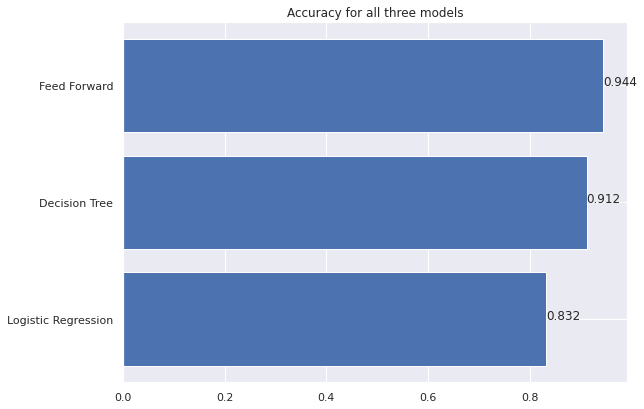

In [ ]:
# All three best model accuracy on the unseen test data
bestLRModelAccuracy = 0.832
bestDTCModelAccuracy = 0.912
bestFFNModelAccuracy = 0.944

ax = plt.figure(figsize=(7,5)).add_axes([0,0,1,1])
modelLabels = ['Logistic Regression', 'Decision Tree', 'Feed Forward']
accuracyScores = [bestLRModelAccuracy,bestDTCModelAccuracy, bestFFNModelAccuracy]
ax.barh(modelLabels, accuracyScores)
ax.set_title("Accuracy for all three models")
for index, value in enumerate(accuracyScores):
    plt.text(value, index, str(value))
plt.show()

The following table summarises the relative accuracy of the chosen model for each type, its f1-score for accuracy (see above graph), and the time taken to train the model.

Model | Accuracy  | Training Time 
-|-|-
Logistic Regression | 83% | 1.0s
Decision Tree | 91% | 0.4s
Feed Forward Neural Network | 94% | 148.2s 

From this table, we can see that there is a large increase in the accuracy when moving from the Logistic Regression (LR) model to both the Decision Tree (DT) model and the Feed Forward Neural Network (FFNN) model. The accuracy of the FFNN is the best - although the DT model is not far behind. As mentioned, we feel that accuracy is the best measurement to use when assessing which model is best. We feel that the accuracy of the LR model is too low for it to be considered an option we can recommend.

The DT and FFNN models both perform to a standard that we would feel comfortable recommending. As the accuracy of both these models is high, some secondary factors come into consideration. Importantly the DT model is very quick to train, so as the size of the data increases we would expect the DT to be more quickly and easily re-trained and re-optimised than the FFNN model.

The Decision Tree model also has a significant advantage over the Feed Forward Neural Network in its transparency. When comparing the two, the FFNN has shown itself to be more able to adjust to nuances in data and is able to take all aspects of customer experience into account when predicting customer satisfaction. The increased accuracy that this yield comes at the cost of opaqueness. It is very difficult to reverse-engineer why the model has predicted the way it has. The DT model, however, is able to be reverse-engineered much more simply. Each decision along the tree shows a clear dividing point that humans are able to interpret. The company could, therefore, analyse the largest groups of satisfied and unsatisfied customers and will be able to see which decisions along the tree have divided them in this way. This becomes extremely important when the business is trying to make decisions to improve customer satisfaction. It is no use knowing that a customer will be unsatisfied if there is no information that can be garnered as to how to prevent other customers from being unsatisfied in the future.

> Due to its transparency combined with its high accuracy and fast training time - **the Decision Tree model is the model we suggest should be implemented** to predict customer satisfaction.

Of course, the reason we would go through this machine learning process is not just to predict customer satisfaction, but to determine what a business can do to improve customer satisfaction as efficiently and as cost effectively as possible. 

Through our analysis, there were some features that we were able to use to predict customer satisfaction to an accuracy of 95%. Some of these features are beyond the feasible control of the business (for example gender, age of the customer, current type of customer, type of travel). There were a number of features that the company has strong control over (for example ease of online booking, food and drink, cleanliness).

Finally given we have evaluated all our models on unseen data, would safely predict our models to be within the range of +-1% or 2% of their above values. There was a variance between our development test scores and that of the final unseen data, so some variance would be expected. This would give our decision tree an estimated 89%-93% predicted accuracy overall.  










# Business Recommendations

We will discuss the features we found were best when used with the Decision Tree model with regards to recommending action to be taken to increase customer satisfaction.

## Decisions that should be based on factors other than satisfaction.

*This section of features is not able to be acted upon without considering other significant factors. Although these form part of an accurate prediction model they are not able to be easily adjusted towards the aim of increased customer satisfaction.*

* CUSTOMER TYPE

The high correlation between customer type (loyal or disloyal) and satisfaction can be attributed to the influence that satisfaction has on loyalty (Ibojo & Asabi 2015). Although customer loyalty programs are worthwhile and encouraged - our recommendation will be to increase satisfaction in other ways so that loyalty can be influenced by satisfaction - not the other way around.

* TYPE OF TRAVEL

The type of travel is split into personal and business travel. Satisfaction levels for business customers are high, whereas people who travel for personal reasons have lower satisfaction levels. The decision to pursue a higher percentage of business customers vs people travelling for personal reasons is a broader business decision. Focusing on one demographic at the expense of another may negatively influence profit. This decision should not be based on satisfaction levels, but on sound financial projections and reasoning.

* CLASS

It is assumed for the purposes of this report that the proportion of seats allocated to different classes is not alterable. Should one section be regularly over-booked when another section is regularly under-booked, then different types and layouts of aircraft should be considered when updating the fleet. Satisfaction should not be the driving decision behind this. Upgrading a whole plane to first class would satisfy everyone - but likely ruin the business.

* DEPARTURE/ARRIVAL TIME CONVENIENT

The convenience of arrival and departure times are different for every customer. It is up to the customer to choose the best flight for their itinerary, and it is up to the airline to offer as many flights as they can while optimising profitability. Adding extra flights to accommodate only a few passengers will be a costly exercise. Times to leave and arrive depend heavily on available scheduling at the airports being flown through. Airlines already provide cheaper options for flights that are outside of the most popular times to ensure that more flights can be offered, but the number of flights running essentially must be based on projected demand.

## High ROI features
These features have a high correlation with customer satisfaction and can be improved upon relatively simply. These are the high ROI (return on investment) recommendations that should be the first focus of the business to increase customer satisfaction levels.

* INFLIGHT WIFI SERVICE & ONLINE BOARDING

Using and accessing technology is a high priority for many people. Being able to rate an online boarding service highly and being able to access Wifi service inflight are high priorities for customers. These factors increase satisfaction significantly. Our recommendation is to continue to monitor the efficiency of these services, ensure strong internet connections in-flight and at the airport, and explore other features that can support technologically minded customers (e.g. charging ports, laptop-friendly tray tables).

* CLEANLINESS

This is an excellent way to increase satisfaction. Keeping the fleet clean should be part of the core business of the airline - and cleanliness affects satisfaction levels. As a percentage of revenue, hiring more cleaners could be a cost effective way to increase satisfaction. Walking past rows of pristinely cleaned seats with organised magazines and clean facilities gives the best chance of a positive cleanliness rating.

* AVERAGESERVICE

This is an aggregate score of all of the service satisfaction scores. This is an area that most airlines excel in already. Improving the service that is received from staff comes down to having consistent, easy to follow procedures for customer support, having support for staff available to fix issues should they arise, and most importantly - ensuring staff are happy. It's much easier to consistently display positivity and provide good service if you are happy, enjoying yourself, and able to understand your role clearly. With strong staff support and positive culture within the company, the overall service levels should improve, leading to more satisfied customers.

## Recommendations requiring creative problem solving
This group of features show a correlation with satisfaction but are not as easily or cheaply improved upon.

* TOTALDELAY

We never aim to delay a flight. I would expect the schedule of flight arrivals, departures, maintenance, cleaning, change-over time, refuelling, etc. to be continually monitored and optimised by any airline. Delays are, however, inevitable. Providing some services to people who have flights delayed could make it a more positive experience. The difficulty lies in the unpredictability of delays, and the unpredictable behaviour of passengers when flights are delayed. Some entertainment or small snacks/gifts at the terminal for significantly delayed flights would likely improve satisfaction levels. Having these things on standby and used in such an unpredictable manner may not improve customer satisfaction to a point that would justify the expense and logistic difficulties involved. Handing out gifts would require stock levels with unpredictable supply requirements. Passengers may not necessarily stay at a set location to receive the compensation either.

* CHECKIN SERVICE

A highly rated check-in service correlates strongly with satisfaction. Ensuring this process continues to be quick, efficient, and friendly should be a high priority. Due to the influence of a positive check-in experience on customer satisfaction, exploring how to improve this experience will be worthwhile. Having staff on hand to guide people to the correct line and positively entertain or distract them from any wait they may be experiencing could reduce the negative impact a wait might have when it is unavoidable. Providing small gifts for children in line could make the experience more positive for them - especially since this demographic has shown low satisfaction rates in the data set. The CHECKIN SERVICE feature has a similar issue to the TOTALDELAY feature where it can be, to some extent, unpredictable depending on customer complexity. The suggestions above will help increase satisfaction but will be difficult to implement effectively due to unpredictability and the constant moving of the line during the check-in process.



# APPENDIX / OTHER


**RFE OUTPUT:**

TESTING THESE RELEVANT COLUMNS
Index(['TYPE OF TRAVEL'], dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL'], dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING'], dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING', 'AVERAGESERVICE'], dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING', 'CLEANLINESS',
       'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING', 'CHECKIN SERVICE',
       'CLEANLINESS', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'ONLINE BOARDING', 'CHECKIN SERVICE', 'CLEANLINESS', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'ONLINE BOARDING', 'CHECKIN SERVICE', 'CLEANLINESS', 'COMFORT',
       'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'COMFORT', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'COMFORT', 'TOTALDELAY',
       'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'EASE OF ONLINE BOOKING',
       'ONLINE BOARDING', 'CHECKIN SERVICE', 'CLEANLINESS', 'COMFORT',
       'TOTALDELAY', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'EASE OF ONLINE BOOKING',
       'FOOD AND DRINK', 'ONLINE BOARDING', 'CHECKIN SERVICE', 'CLEANLINESS',
       'COMFORT', 'TOTALDELAY', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'DEPARTURE/ARRIVAL TIME CONVENIENT', 'EASE OF ONLINE BOOKING',
       'FOOD AND DRINK', 'ONLINE BOARDING', 'CHECKIN SERVICE', 'CLEANLINESS',
       'ORDER', 'COMFORT', 'TOTALDELAY', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['GENDER', 'CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS',
       'INFLIGHT WIFI SERVICE', 'DEPARTURE/ARRIVAL TIME CONVENIENT',
       'EASE OF ONLINE BOOKING', 'FOOD AND DRINK', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'ORDER', 'COMFORT', 'TOTALDELAY',
       'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['GENDER', 'CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS',
       'INFLIGHT WIFI SERVICE', 'DEPARTURE/ARRIVAL TIME CONVENIENT',
       'EASE OF ONLINE BOOKING', 'FOOD AND DRINK', 'ONLINE BOARDING',
       'INFLIGHT ENTERTAINMENT', 'CHECKIN SERVICE', 'CLEANLINESS', 'ORDER',
       'COMFORT', 'TOTALDELAY', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['GENDER', 'CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS',
       'INFLIGHT WIFI SERVICE', 'DEPARTURE/ARRIVAL TIME CONVENIENT',
       'EASE OF ONLINE BOOKING', 'FOOD AND DRINK', 'ONLINE BOARDING',
       'SEAT COMFORT', 'INFLIGHT ENTERTAINMENT', 'CHECKIN SERVICE',
       'CLEANLINESS', 'ORDER', 'COMFORT', 'TOTALDELAY', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['GENDER', 'CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS',
       'INFLIGHT WIFI SERVICE', 'DEPARTURE/ARRIVAL TIME CONVENIENT',
       'EASE OF ONLINE BOOKING', 'GATE LOCATION', 'FOOD AND DRINK',
       'ONLINE BOARDING', 'SEAT COMFORT', 'INFLIGHT ENTERTAINMENT',
       'CHECKIN SERVICE', 'CLEANLINESS', 'ORDER', 'COMFORT', 'TOTALDELAY',
       'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['GENDER', 'CUSTOMER TYPE', 'AGE', 'TYPE OF TRAVEL', 'CLASS',
       'INFLIGHT WIFI SERVICE', 'DEPARTURE/ARRIVAL TIME CONVENIENT',
       'EASE OF ONLINE BOOKING', 'GATE LOCATION', 'FOOD AND DRINK',
       'ONLINE BOARDING', 'SEAT COMFORT', 'INFLIGHT ENTERTAINMENT',
       'CHECKIN SERVICE', 'CLEANLINESS', 'ORDER', 'COMFORT', 'TOTALDELAY',
       'AVERAGESERVICE'],
      dtype='object')


In [ ]:
# This was used to determine the greedy evaluated metrics
# Takes an existing set ["CLASS"] and iterates over for the next best f1 score
#   by adding 1 paramater at a time
# you then can add the best one and try again
def myGreedyNextBestFinder(existingSet):
    model = LogisticRegression(max_iter=10000)
    # MOVED TO TOF - from sklearn.metrics import f1_score
    bestCol = ""
    highPer = 0
    allV = set(all)
    remainder = allV.difference(robs)

    for value in remainder:
        copy1 = existingSet.copy()
        copy1.add(value)
        X_train, X_test, Y_train, Y_test = train_test_split(trainDf[copy1], trainDf['SATISFACTION'], test_size=0.3, random_state=1234)

        Y_pred_train, Y_pred_test = getPredictions(X_train, Y_train, X_test, model)
        if f1_score(Y_train, Y_pred_train) > highPer:
            highPer = f1_score(Y_train, Y_pred_train)
            bestCol = value    
    print(bestCol, highPer)
    return (bestCol)

# using tools from sklearn
# MOVED TO TOF - from sklearn.feature_selection import RFE
# returns prediction
def getImportantFeatures(model, numberFeatures, data, target):
    # create the RFE model and select 3 attributes
    rfe = RFE(model, n_features_to_select=numberFeatures)
    rfe = rfe.fit(data, target)
    # summarize the selection of the attributes
    print("TESTING THESE RELEVANT COLUMNS")
    print(data.loc[:,rfe.support_].columns)
    return rfe.predict(data)


# Warning will take a while 30+mins,  so i have commented it out as to not force you to sit through it
# Try all permutations and store the scores and we will plot after on a graph

# f1Score = [0]
# accuracies = [0]
# mserrors = [0]
# r2Score = [0]
# numberOfFeatures = len(transformedTrainDFCols)

# for i in range(1, numberOfFeatures):
#     prediction = getImportantFeatures(LogisticRegression(max_iter=10000), i, X_train[transformedTrainDFCols], Y_train)
#     report = classification_report(Y_train, prediction, output_dict=True)
#     macroF1 = report['macro avg']['f1-score']
#     accuracy = report['accuracy']
#     mse = mean_squared_error(Y_train, prediction)
#     r2 = r2_score(Y_train, prediction)
#     f1Score.append(macroF1)
#     accuracies.append(accuracy)
#     mserrors.append(mse)
#     r2Score.append(r2)

# print(f1Score)
# print(accuracies)
# print(mserrors)
# print(r2Score)

TESTING THESE RELEVANT COLUMNS
Index(['TYPE OF TRAVEL'], dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL'], dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING'], dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING', 'AVERAGESERVICE'], dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING', 'CLEANLINESS',
       'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'ONLINE BOARDING', 'CHECKIN SERVICE',
       'CLEANLINESS', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'ONLINE BOARDING',
       'CHECKIN SERVICE', 'CLEANLINESS', 'AVERAGESERVICE'],
      dtype='object')
TESTING THESE RELEVANT COLUMNS
Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIG

SFS Code and Output

In [ ]:
# SFS-Backward SequentialFeatureSelector   takes about 15 minuts 
from sklearn.feature_selection import SequentialFeatureSelector

#Selecting the Best important features according to Logistic Regression
sfs_selector = SequentialFeatureSelector(estimator=LogisticRegression(max_iter=4000), n_features_to_select=10, cv=10, direction ='forward')

sfs_selector.fit(X_train, Y_train)
print(f'Best features found via SFS: {X_train.columns[sfs_selector.get_support()]}')

# ## Test the feature set in the same way we have the other models for uniformity and speed
# sfsAccuracy, sfsTestAccuracy, sfsDuration = trainPrintAndReturnMetric(X_train.columns[sfs_selector.get_support()], X_train, X_test, Y_train, Y_test)


Best features found via SFS: Index(['CUSTOMER TYPE', 'TYPE OF TRAVEL', 'CLASS', 'INFLIGHT WIFI SERVICE',
       'ONLINE BOARDING', 'CHECKIN SERVICE', 'CLEANLINESS', 'ORDER',
       'TOTALDELAY', 'AVERAGESERVICE'],
      dtype='object')
